# Домашнее задание 3

У вас есть данные о полетах. Для каждого клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета. 

Для некоторых клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied). По этим данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, для которых ответ неизвестен.

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

Продуктивной и интересной вам работы!

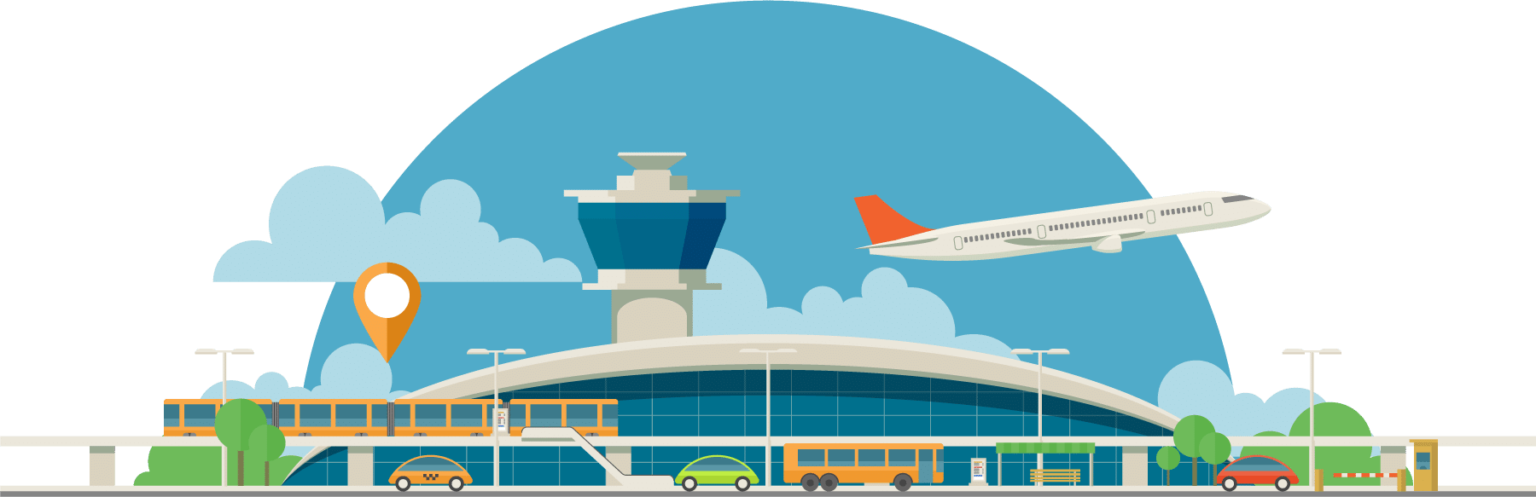

> Задания, <font color='#9933CC'>выделенные фиолетовым</font>, требуют от вас написания кода. <br/> А вопросы, <font color='#FF6600'>выделенные оранжевым</font>, -- текстового ответа.

Оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.

Брать код из открытых источников позволительно. Следование культуре цитирования при этом обязательно

In [5]:
# !pip install catboost
# !pip install mlxtend --upgrade
# !pip install optuna
# !pip install lime
# !pip install shap
# !pip install missingno
# !pip install psycopg2-binary
# !pip install xgboost
# !brew install cmake libomp
# !pip install lightgbm

  Using cached xgboost-2.0.3-py3-none-macosx_12_0_arm64.whl.metadata (2.0 kB)
Using cached xgboost-2.0.3-py3-none-macosx_12_0_arm64.whl (1.9 MB)
  Using cached lightgbm-4.2.0.tar.gz (1.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for lightgbm (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [46 lines of output]
      2023-12-28 14:07:41,843 - scikit_build_core - INFO - CMake version: 3.28.1
      *** scikit-build-core 0.7.0 using CMake 3.28.1 (wheel)
      2023-12-28 14:07:41,848 - scikit_build_core - INFO - Build directory: /private/var/folders/kk/prpnwxyn19v358s1w33y_n2c0000gn/T/tmpg3ia23_n/build
      *** Configuring CMake...
      2023-12-28 14:07:41,999 - scikit_build_core - INFO - Ninja version: 1.11.1
      2023-12-28 14:07:41,999 - scikit_build_core - WARNING - libd

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions 
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)

# Data Prep & EDA (3 балла)

## Загрузка и предобработка данных (1.75 балла)

In [12]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" --no-check-certificate \
    --output-document ~/.postgresql/root.crt &&  \
chmod 0600 ~/.postgresql/root.crt 

--2023-12-28 14:20:49--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
  Self-signed certificate encountered.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: '/Users/msk-hq-nb-2783/.postgresql/root.crt'

/Users/msk-hq-nb-27 100%[===================>]   3.50K  --.-KB/s    in 0s      

2023-12-28 14:20:49 (3.33 GB/s) - '/Users/msk-hq-nb-2783/.postgresql/root.crt' saved [3579/3579]



(0.5 балла) <font color='#9933CC'>Подключитесь к БД при помощи `psycopg2.connect()` и напишите SQL-запрос, объединяющий 3 нужные таблицы в одну</font>.
Список столбцов таблиц добудьте самостоятельно. 

<font color='#9933CC'>Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'</font>

> Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

### Параметры соединения
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write
```

### Схема БД

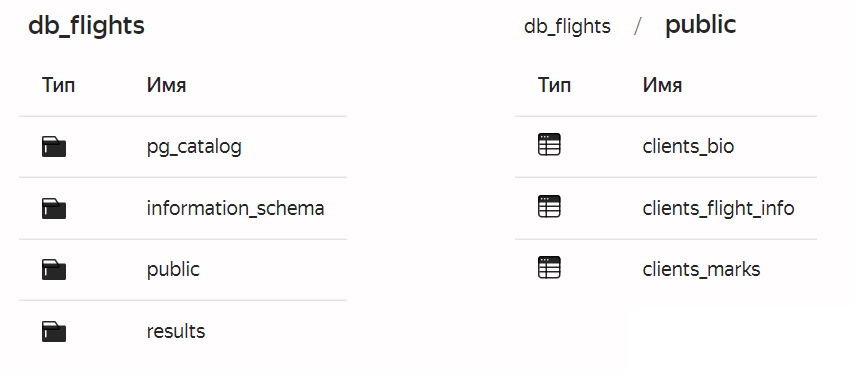

In [3]:
# your code below
host="rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net"
port=6432
sslmode="verify-full"
dbname="db_flights"
user="mlhs_student"
password="mlhs_student"
target_session_attrs="read-write"

SQL_QUERY = """
    SELECT *
    FROM clients_bio
    INNER JOIN 
    clients_flight_info
    USING(id)
    INNER JOIN
    clients_marks
    USING(id)
"""

pg_conn = psycopg2.connect(
        host=host, 
        port=port, 
        sslmode=sslmode, 
        dbname=dbname, 
        user=user, 
        password=password, 
        target_session_attrs=target_session_attrs,
    )

cursor = pg_conn.cursor()

cursor.execute(SQL_QUERY)

col_names = [x[0] for x in cursor.description]

df = pd.DataFrame(cursor.fetchall(), columns=col_names)
df.set_index("id", inplace=True)

pg_conn.close()

In [4]:
pd.set_option("display.max_columns", 23)
df.head(5)

gender   age      Customer Type   Type of Travel     class  \
id                                                               
7     Male  43.0     Loyal Customer  Business travel  Business   
13    Male  24.0  disloyal Customer  Business travel       Eco   
18  Female  61.0     Loyal Customer  Personal Travel       Eco   
31    Male  35.0  disloyal Customer  Business travel  Business   
39  Female  46.0     Loyal Customer  Business travel  Business   

   Flight Distance Departure Delay in Minutes Arrival Delay in Minutes  \
id                                                                       
7           1963.0                        0.0                      0.0   
13           453.0                       16.0                     30.0   
18           821.0                        0.0                      0.0   
31           212.0                        0.0                      0.0   
39            67.0                        0.0                      0.0   

   Inflight wifi service Departure/Arrival time convenient  \
id                                                           
7                    3.0                               3.0   
13                   2.0                               2.0   
18                   2.0                               5.0   
31                   2.0                               2.0   
39                   3.0                               3.0   

   Ease of Online booking Gate location Food and drink Online boarding  \
id                                                                       
7                     3.0           3.0            5.0             4.0   
13                    2.0           4.0            5.0             2.0   
18                    2.0           1.0            4.0             1.0   
31                    2.0           1.0            2.0             2.0   
39                    3.0           3.0            4.0             5.0   

   Seat comfort Inflight entertainment On-board service Leg room service  \
id                                                                         
7           5.0                    5.0              5.0              5.0   
13          5.0                    5.0              2.0              4.0   
18          5.0                    5.0              5.0              2.0   
31          2.0                    2.0              4.0              5.0   
39          4.0                    4.0              4.0              4.0   

   Baggage handling Checkin service Inflight service cleanliness  \
id                                                                 
7               5.0             4.0              5.0         4.0   
13              4.0             2.0              4.0         5.0   
18              5.0             5.0              5.0         1.0   
31              5.0             5.0              4.0         2.0   
39              4.0             5.0              4.0         5.0   

               satisfaction  
id                           
7                 satisfied  
13  neutral or dissatisfied  
18  neutral or dissatisfied  
31  neutral or dissatisfied  
39                satisfied

In [5]:
assert df.shape == (129_549, 23)

(0.25 балла) <font color='#9933CC'>Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [6]:
# your code below
obj_columns = ["gender", "Customer Type", "Type of Travel", "class", "satisfaction"]
digit_columns = list(set(df.columns)-set(obj_columns))

df[digit_columns] = df[digit_columns].astype(float)

In [7]:
df.describe(percentiles=[.25, .5, .75, .95, .99])

age  Flight Distance  Departure Delay in Minutes  \
count  129234.000000    129455.000000               129442.000000   
mean       40.116951      1322.922158                   15.809026   
std        20.376129      4517.816532                   93.276882   
min         0.000000         0.000000                    0.000000   
25%        27.000000       414.000000                    0.000000   
50%        40.000000       846.000000                    0.000000   
75%        51.000000      1744.000000                   12.000000   
95%        64.000000      3399.000000                   78.000000   
99%        72.000000      3904.000000                  183.000000   
max       621.000000    379620.000000                22227.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count             129042.000000          129505.000000   
mean                  16.656499               2.732327   
std                  109.285072               1.360033   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
95%                   79.000000               5.000000   
99%                  185.000000               5.000000   
max                14006.000000              45.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                      129500.000000           129506.000000   
mean                            3.062131                2.760722   
std                             1.559627                1.431048   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
95%                             5.000000                5.000000   
99%                             5.000000                5.000000   
max                            45.000000               45.000000   

       Gate location  Food and drink  Online boarding   Seat comfort  \
count  129512.000000   129499.000000    129503.000000  129502.000000   
mean        2.981708        3.208141         3.256782       3.445669   
std         1.312873        1.357546         1.381888       1.349713   
min         0.000000        0.000000         0.000000       0.000000   
25%         2.000000        2.000000         2.000000       2.000000   
50%         3.000000        3.000000         3.000000       4.000000   
75%         4.000000        4.000000         4.000000       5.000000   
95%         5.000000        5.000000         5.000000       5.000000   
99%         5.000000        5.000000         5.000000       5.000000   
max        36.000000       45.000000        40.000000      45.000000   

       Inflight entertainment  On-board service  Leg room service  \
count           129504.000000     129505.000000     129503.000000   
mean                 3.361232          3.387259          3.355976   
std                  1.366908          1.335697          1.361670   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
95%                  5.000000          5.000000          5.000000   
99%                  5.000000          5.000000          5.000000   
max                 45.000000         45.000000         40.000000   

       Baggage handling  Checkin service  Inflight service    cleanliness  
count     129501.000000    129507.000000     129486.000000  129512.000000  
mean           3.635872         3.309976          3.646927       3.289780  
std            1.222039         1.298827          1.218748       1.347466  
min         

In [8]:
df.describe(include="object")

gender   Customer Type   Type of Travel     class  \
count   129549          129549           129549    129549   
unique       2               3                3         4   
top     Female  Loyal Customer  Business travel  Business   
freq     65726          105763            89405     61939   

                   satisfaction  
count                    129549  
unique                        3  
top     neutral or dissatisfied  
freq                      58732

In [9]:
df.isna().sum()

gender                                 0
age                                  315
Customer Type                          0
Type of Travel                         0
class                                  0
Flight Distance                       94
Departure Delay in Minutes           107
Arrival Delay in Minutes             507
Inflight wifi service                 44
Departure/Arrival time convenient     49
Ease of Online booking                43
Gate location                         37
Food and drink                        50
Online boarding                       46
Seat comfort                          47
Inflight entertainment                45
On-board service                      44
Leg room service                      46
Baggage handling                      48
Checkin service                       42
Inflight service                      63
cleanliness                           37
satisfaction                           0
dtype: int64

(0.5 балла) <font color='#9933CC'>Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме</font>

Нас интересует `matrix` пропущенных значений и столбцатая диаграмма в логарифмированной шкале (*пропусков немного => по обычной не будет видно, в каких столбцах их больше*)

<Axes: >

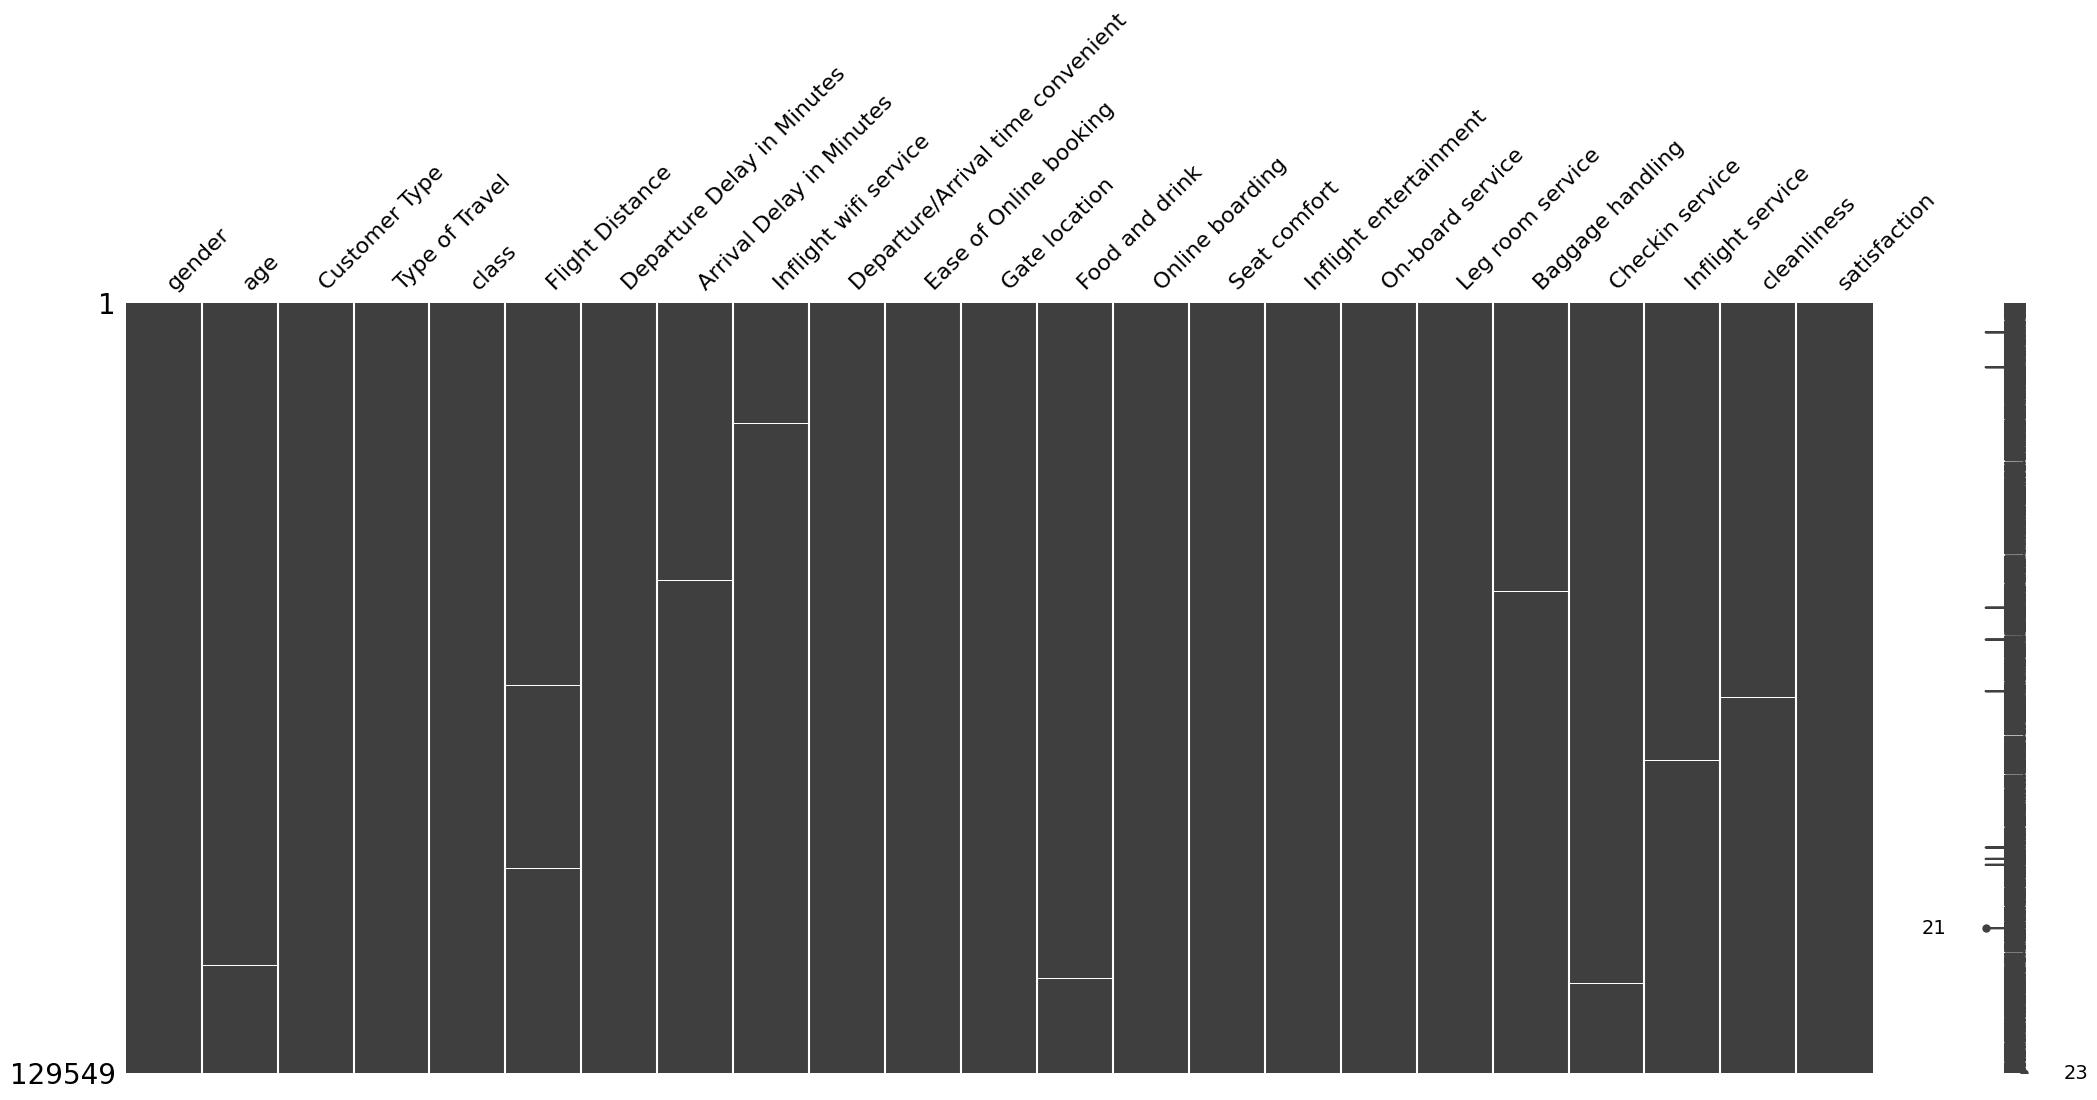

In [148]:
# your code below
%matplotlib inline
missingno.matrix(df)

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


<Axes: >

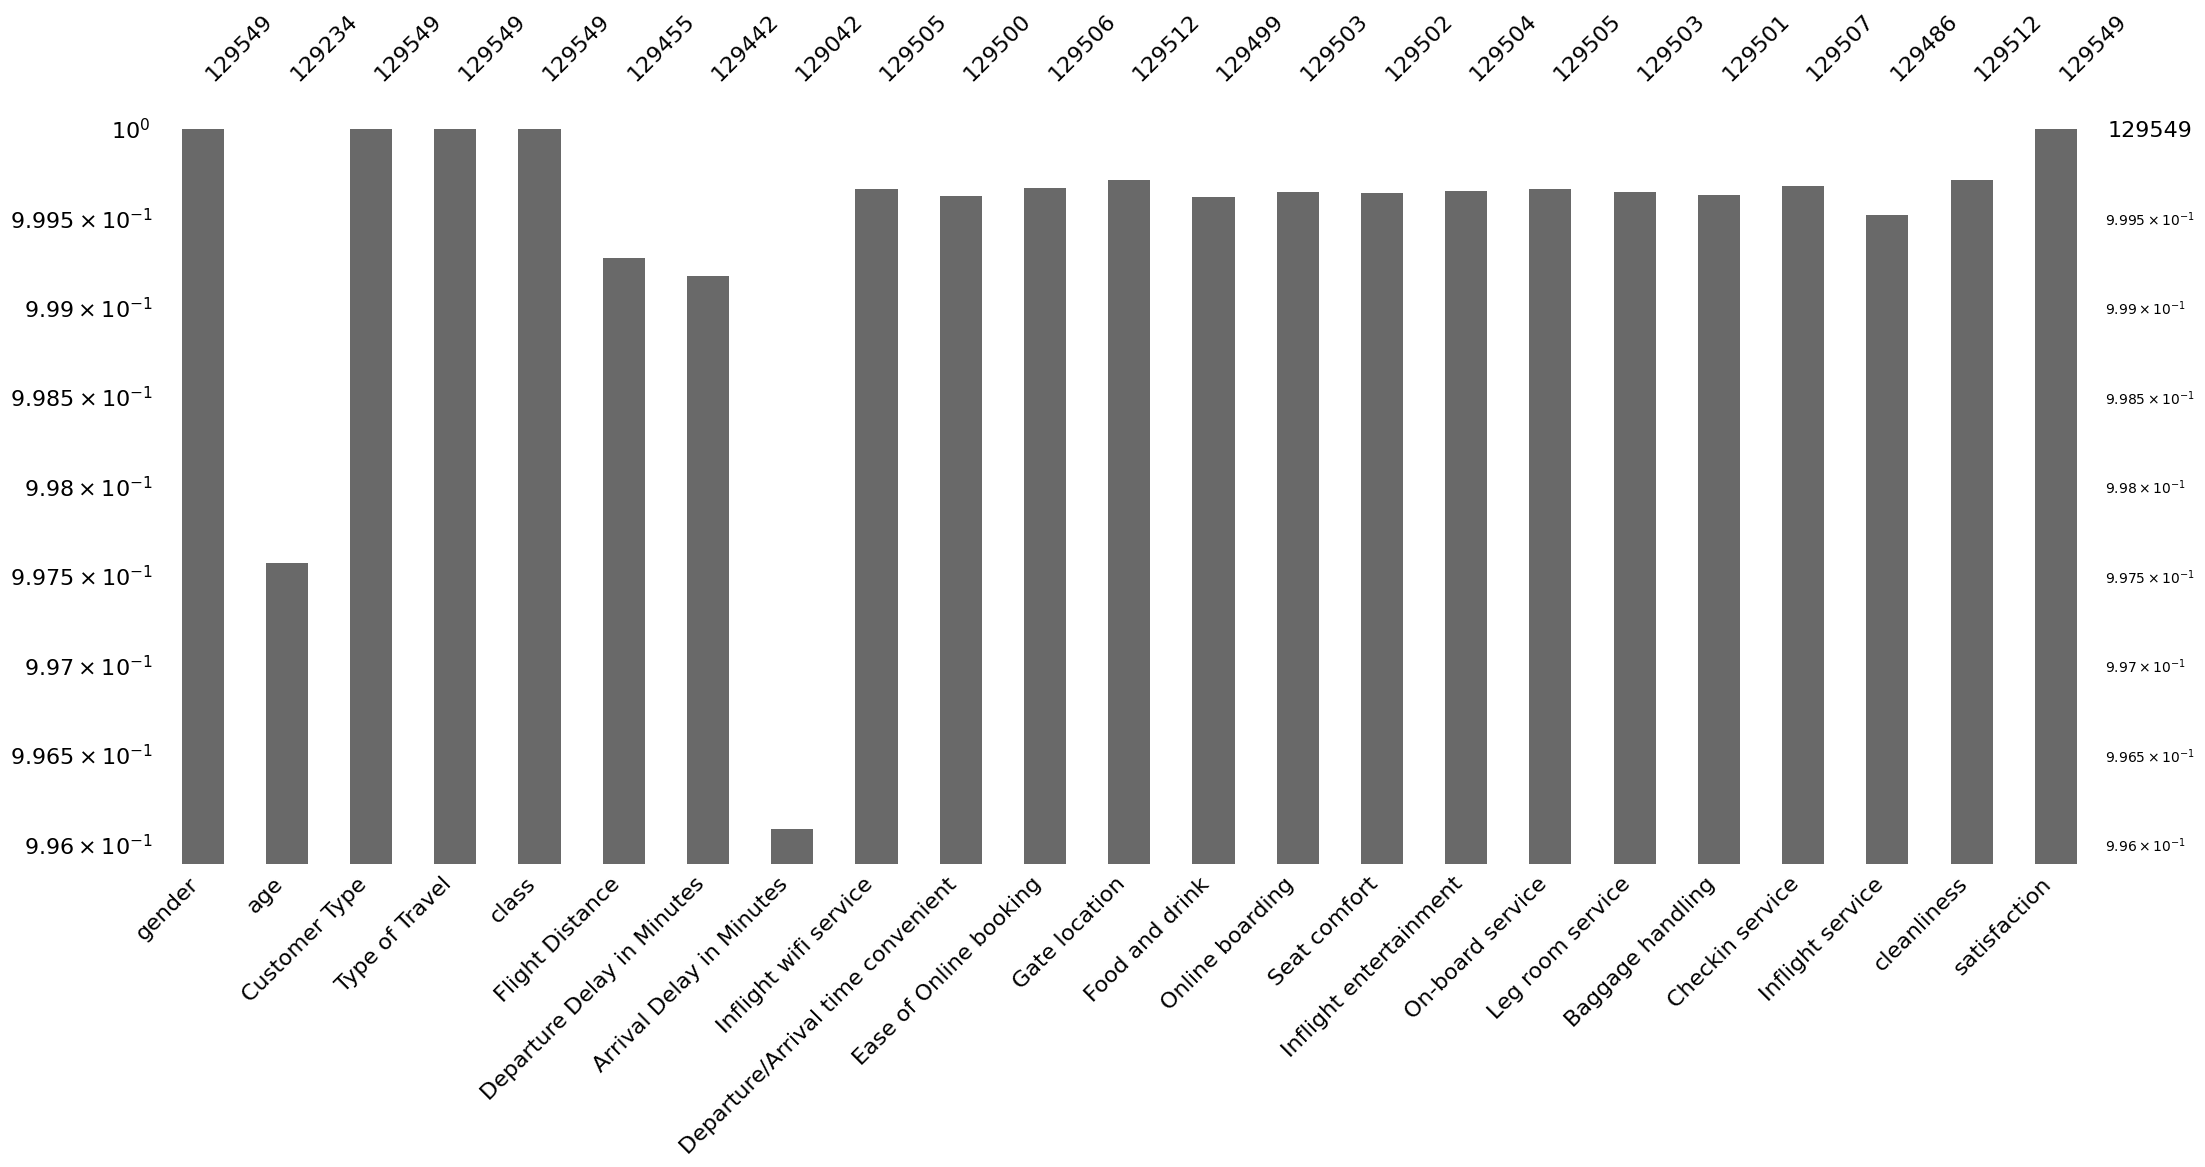

In [150]:
# your code below

missingno.bar(df, log=True)

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука

In [148]:
df_train = df[df.satisfaction != '-']
df_train

gender   age      Customer Type   Type of Travel     class  \
id                                                                   
7         Male  43.0     Loyal Customer  Business travel  Business   
13        Male  24.0  disloyal Customer  Business travel       Eco   
18      Female  61.0     Loyal Customer  Personal Travel       Eco   
31        Male  35.0  disloyal Customer  Business travel  Business   
39      Female  46.0     Loyal Customer  Business travel  Business   
...        ...   ...                ...              ...       ...   
129831  Female  28.0     Loyal Customer  Personal Travel       Eco   
129837    Male  66.0     Loyal Customer  Personal Travel       Eco   
129838  Female  59.0     Loyal Customer  Personal Travel       Eco   
129839    Male  61.0     Loyal Customer  Personal Travel       Eco   
129846    Male  44.0     Loyal Customer  Personal Travel       Eco   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
7                1963.0                         0.0                       0.0   
13                453.0                        16.0                      30.0   
18                821.0                         0.0                       0.0   
31                212.0                         0.0                       0.0   
39                 67.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129831            447.0                        23.0                      16.0   
129837            337.0                       199.0                     213.0   
129838            308.0                        32.0                      24.0   
129839            337.0                         0.0                       0.0   
129846            447.0                         0.0                       0.0   

        Inflight wifi service  Departure/Arrival time convenient  \
id                                                                 
7                         3.0                                3.0   
13                        2.0                                2.0   
18                        2.0                                5.0   
31                        2.0                                2.0   
39                        3.0                                3.0   
...                       ...                                ...   
129831                    1.0                                3.0   
129837                    2.0                                4.0   
129838                    3.0                                5.0   
129839                    2.0                                4.0   
129846                    2.0                                5.0   

        Ease of Online booking  Gate location  Food and drink  \
id                                                              
7                          3.0            3.0             5.0   
13                         2.0            4.0             5.0   
18                         2.0            1.0             4.0   
31                         2.0            1.0             2.0   
39                         3.0            3.0             4.0   
...                        ...            ...             ...   
129831                     1.0            5.0             3.0   
129837                     2.0            3.0             2.0   
129838                     3.0            4.0             2.0   
129839                     2.0            3.0             3.0   
129846                     2.0            3.0             5.0   

        Online boarding  Seat comfort  Inflight entertainment  \
id                                                              
7                   4.0           5.0                     5.0   
13                  2.0           5.0                     5.0   
18                  1.0           5.0               

In [149]:
assert df_train.shape == (103_644, 23)

In [150]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test

gender   age   Customer Type   Type of Travel     class  \
id                                                                
55        Male  36.0  Loyal Customer  Business travel  Business   
79      Female  70.0  Loyal Customer  Personal Travel       Eco   
126       Male  66.0  Loyal Customer  Personal Travel       Eco   
199     Female  60.0  Loyal Customer  Business travel  Business   
263       Male  43.0  Loyal Customer  Personal Travel  Business   
...        ...   ...             ...              ...       ...   
129750    Male  38.0  Loyal Customer  Business travel       Eco   
129771    Male  16.0  Loyal Customer  Personal Travel       Eco   
129798  Female  43.0  Loyal Customer  Personal Travel       Eco   
129868    Male  47.0  Loyal Customer  Business travel  Eco Plus   
129876    Male  28.0  Loyal Customer  Personal Travel  Eco Plus   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
55               3655.0                        40.0                      71.0   
79                108.0                        50.0                      41.0   
126               562.0                        88.0                      84.0   
199              3756.0                        36.0                      24.0   
263               802.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129750            337.0                        92.0                      82.0   
129771            308.0                         2.0                       0.0   
129798            308.0                         0.0                       0.0   
129868            447.0                         0.0                       0.0   
129876            447.0                         2.0                       3.0   

        Inflight wifi service  Departure/Arrival time convenient  \
id                                                                 
55                        1.0                                1.0   
79                        5.0                                4.0   
126                       2.0                                5.0   
199                       4.0                                4.0   
263                       1.0                                2.0   
...                       ...                                ...   
129750                    4.0                                3.0   
129771                    3.0                                4.0   
129798                    2.0                                4.0   
129868                    3.0                                4.0   
129876                    4.0                                4.0   

        Ease of Online booking  Gate location  Food and drink  \
id                                                              
55                         1.0            1.0             1.0   
79                         0.0            3.0             4.0   
126                        2.0            4.0             5.0   
199                        4.0            4.0             2.0   
263                        1.0            3.0             2.0   
...                        ...            ...             ...   
129750                     3.0            3.0             4.0   
129771                     3.0            3.0             1.0   
129798                     2.0            2.0             3.0   
129868                     4.0            4.0             4.0   
129876                     4.0            2.0             4.0   

        Online boarding  Seat comfort  Inflight entertainment  \
id                                                              
55                  3.0           3.0                     3.0   
79                  4.0           4.0                     3.0   
126                 2.0           5.0                     5.0   
199                 4.0   

In [151]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [152]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [153]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

(0.25 балла) <font color='#9933CC'>Заполните пропуски в данных наиболее часто встречающимся значением</font>.
Обратите внимание, что правильная стратегия заполнения пропусков выглядит так:

* посчитать моды для `X_train`
* ими заполнить пропуски в `X_train`, `X_val` и `df_test`

Было бы неплохо воспользоваться другой стратегией: восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Но для признаков в нашей задаче они в чистом виде бы, увы, скорее, не подошли. Импьютеры возвращали бы вещественные значения, а в нашей задаче все признаки целые. 

В общем, для изящного и удобного для применения в пайплайне заполнения пропусков, пришлось бы кодить самописные классы. Этим можете заняться в бонусной части.

In [154]:
# your code below
nan_string_cols = ["Customer Type", "Type of Travel", "class"]
for col in nan_string_cols:
    X_train[col] = X_train[col].replace("nan", np.nan)
    X_val[col] = X_val[col].replace("nan", np.nan)
    df_test[col] = df_test[col].replace("nan", np.nan)

nan_dict = df.drop("satisfaction", axis=1).isna().sum().to_dict()
mode_dict = {}

for col in nan_dict.keys():
    if nan_dict[col] != 0:
        mode = X_train[col].mode()[0]
        mode_dict[col] = mode

X_train = X_train.fillna(value=mode_dict)
X_val = X_val.fillna(value=mode_dict)
df_test = df_test.fillna(value=mode_dict)

<font color='#9933CC'>Выведите основные статистики по числовым и категориальным столбцам таблицы `X_train`</font>

In [155]:
# the place for you to code

display(X_train.describe())
display(X_train.describe(include="object"))

age  Flight Distance  Departure Delay in Minutes  \
count  72550.000000     72550.000000                72550.000000   
mean      40.098856      1329.018332                   15.859366   
std       20.658196      4764.369357                   70.861937   
min        0.000000         0.000000                    0.000000   
25%       27.000000       413.000000                    0.000000   
50%       40.000000       844.000000                    0.000000   
75%       51.000000      1744.000000                   12.000000   
max      544.000000    379620.000000                 9282.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count              72550.000000           72550.000000   
mean                  16.645968               2.733687   
std                   97.990293               1.362172   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
max                11760.000000              45.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                       72550.000000            72550.000000   
mean                            3.065017                2.761006   
std                             1.552254                1.414843   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                            45.000000               28.000000   

       Gate location  Food and drink  Online boarding  Seat comfort  \
count   72550.000000    72550.000000     72550.000000  72550.000000   
mean        2.982688        3.209318         3.256513      3.445665   
std         1.316648        1.349963         1.372739      1.346077   
min         0.000000        0.000000         0.000000      0.000000   
25%         2.000000        2.000000         2.000000      2.000000   
50%         3.000000        3.000000         3.000000      4.000000   
75%         4.000000        4.000000         4.000000      5.000000   
max        36.000000       36.000000        32.000000     45.000000   

       Inflight entertainment  On-board service  Leg room service  \
count            72550.000000      72550.000000      72550.000000   
mean                 3.362150          3.383101          3.352364   
std                  1.360862          1.333758          1.360180   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                 40.000000         45.000000         36.000000   

       Baggage handling  Checkin service  Inflight service   cleanliness  
count      72550.000000     72550.000000      72550.000000  72550.000000  
mean           3.630255         3.309056          3.640234      3.291178  
std            1.227853         1.293114          1.215114      1.343302  
min            0.000000         0.000000          0.000000      0.000000  
25%            3.000000         3.000000          3.000000      2.000000  
50%            4.000000         3.000000          4.000000      3.000000  
75%            5.000000         4.000000          5.000000      4.000000  
max           40.000000        45.000000         36.000000     45.000000

gender   Customer Type   Type of Travel     class
count    72550           72498            72480     72484
unique       2               2                2         3
top     Female  Loyal Customer  Business travel  Business
freq     36816           59354            49984     34727

<font color='#FF6600'>Что вы можете сказать про распределение значений признаков?</font>

У части признаков (`age`, `Flight Distance`, `Departure Delay in Minutes`, `Arrival Delay in Minutes`) высокий разброс в значениях, так как есть тяжелые выбросы в этих колонках. \
У признака `age` есть неадекватное значение - максимальный возраст 544 года. \
У большинства фичей значения - порядковые чиста (те для них не так важна плавающая точка). \
Большинство пассажиров в истории - женщины. Также, чаще всего люди летают в командировки. И летают бизнесс классом. Также, судя по колонке `Customer Type`, самолетами пользуется лояльные пассажиры. 

(0.25 балла) <font color='#9933CC'>Удалите строки c выбросами в числовых столбцах</font> (для трейна и валидации; тест оставьте без изменений). Выбросами считайте значения признака, строго превышающие 0.996-квантиль


---
<br/>

*Откуда взялся именно 0.996-квантиль?*

*В рамках анализа данных на выборсы вы вполне могли заметить, какие значения признаков встречаются редко. В среднем для всех признаков эти значения начинаются ~в этом квантиле*

In [156]:
# place for you to code
cols_ejection = [
    "age", 
    "Flight Distance", 
    "Departure Delay in Minutes", 
    "Arrival Delay in Minutes",
    'Inflight wifi service',
    'Departure/Arrival time convenient', 
    'Ease of Online booking',
    'Gate location', 
    'Food and drink', 
    'Online boarding', 
    'Seat comfort',
    'Inflight entertainment', 
    'On-board service', 
    'Leg room service',
    'Baggage handling', 
    'Checkin service', 
    'Inflight service',
    'cleanliness'
    ]

for col in cols_ejection:
    X_train = X_train[X_train[col] <= X_train[col].quantile(0.99)]
    X_val = X_val[X_val[col] <= X_val[col].quantile(0.99)]

In [157]:
# assert X_train.shape == (71_369, 22) эти ассерты у большинства студентов не проходили
# assert X_val.shape == (30_609, 22) и это совершенно не принципиально
assert df_test.shape == (25_905, 22)

## EDA (1.25 балла)

Создадим переменные с перечислениями столбцов разного типа

In [158]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols)) 
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [159]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

(0.5 балла) <font color='#9933CC'>Напишите процедуры для отрисовки графиков</font>

* Для признаков, которые мы выделили как порядковые, отображайте только `countplot`
* Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)
* Для категориальных -- только `countplot`

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

> Все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима

In [110]:
def plot_ordinal(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    sns.set(rc={'figure.figsize':(8,4)})
    df_plot = df.merge(y, how="inner", on="id")
    for col in cols:
        ax = sns.countplot(df_plot, x=col, hue="satisfaction")
        ax.set(xlabel=col, ylabel="count", title=f"Countplot of {col}")
        plt.setp(ax.get_legend().get_texts(), fontsize='9')
        plt.setp(ax.get_legend().get_title(), fontsize='10')
        plt.show()

In [111]:
def plot_continuous(cols, df, y):
    """Draws kdeplots and boxplots in one row 
    for all columns in 'cols' with informative title 
    """
    df_plot = df.merge(y, how="inner", on="id")
    for col in cols:
        fig, ax = plt.subplots(1, 2, figsize=(10, 6))
        sns.kdeplot(df_plot, x=col, hue="satisfaction", ax=ax[0])
        sns.boxplot(df_plot, x=col, y="satisfaction", hue="satisfaction", ax=ax[1], )
        ax[0].set_xlabel(col)
        ax[0].set_ylabel("density")
        ax[0].set_title(f"Distribution of {col}")
        ax[1].set_xlabel(col)
        ax[1].set_title(f"Boxplot of {col} by target")
        plt.setp(ax[0].get_legend().get_texts(), fontsize='9')
        plt.setp(ax[0].get_legend().get_title(), fontsize='10')
        plt.show()

In [112]:
def plot_categorical(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    sns.set(rc={'figure.figsize':(8,4)})
    df_plot = df.merge(y, how="inner", on="id")
    for col in cols:
        ax = sns.countplot(df_plot, x=col, hue="satisfaction")
        ax.set(xlabel=col, ylabel="count", title=f"Countplot of {col}")
        plt.setp(ax.get_legend().get_texts(), fontsize='9')
        plt.setp(ax.get_legend().get_title(), fontsize='10')
        plt.show()

<font color='#9933CC'>Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне</font>

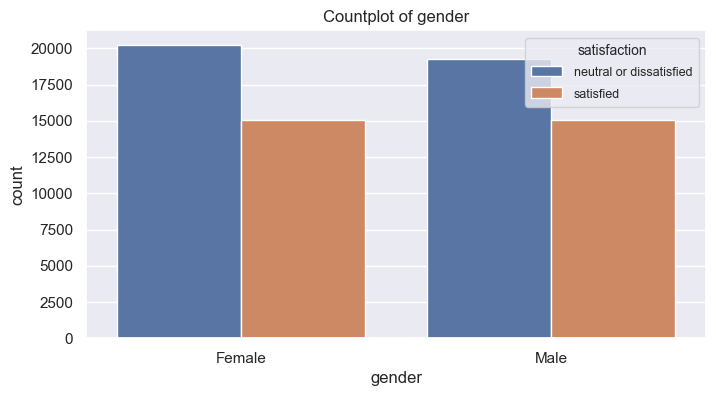

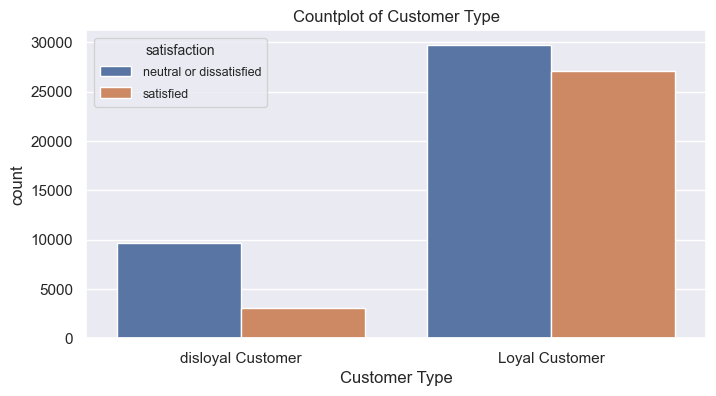

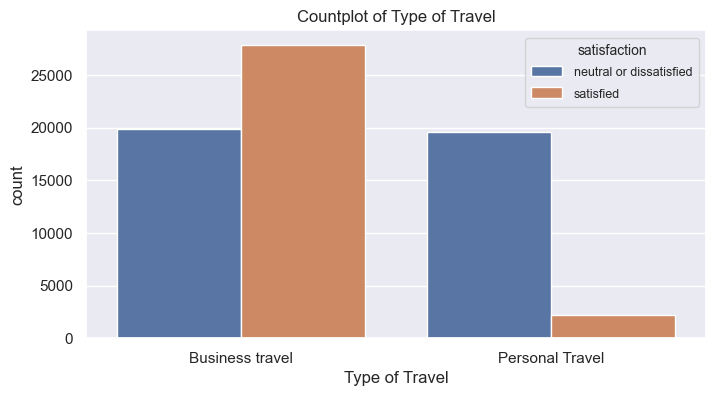

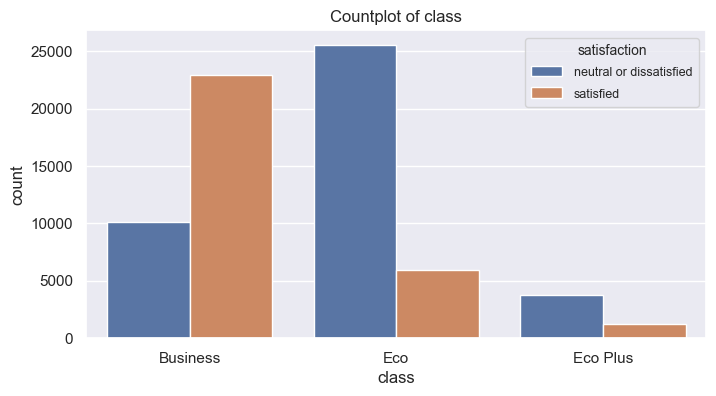

In [114]:
plot_categorical(categorical_cols, X_train, y_train)

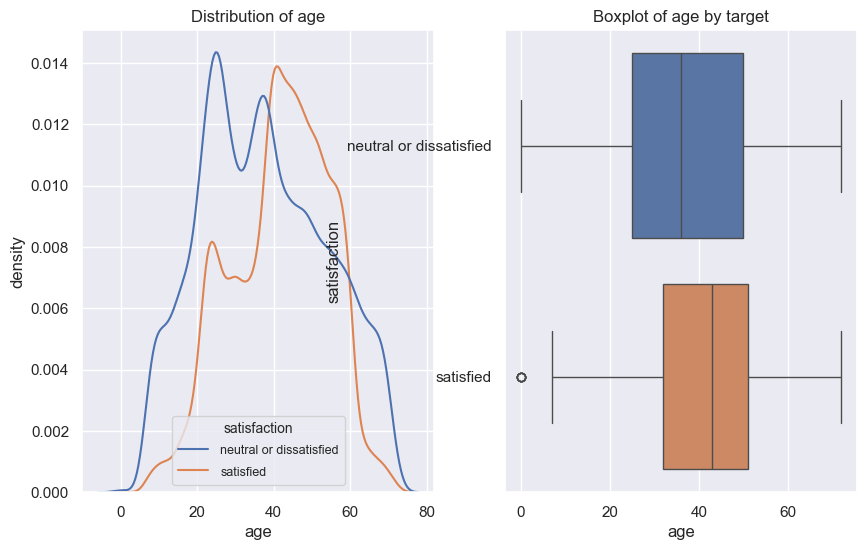

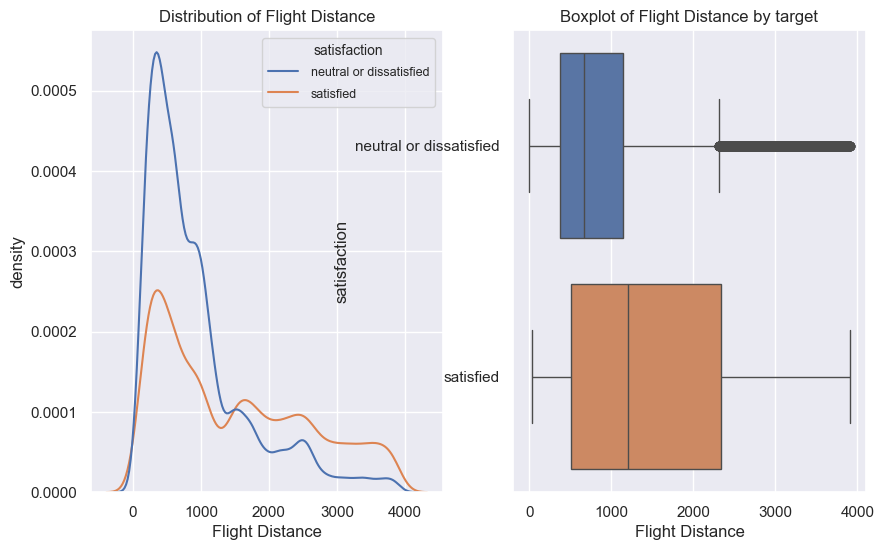

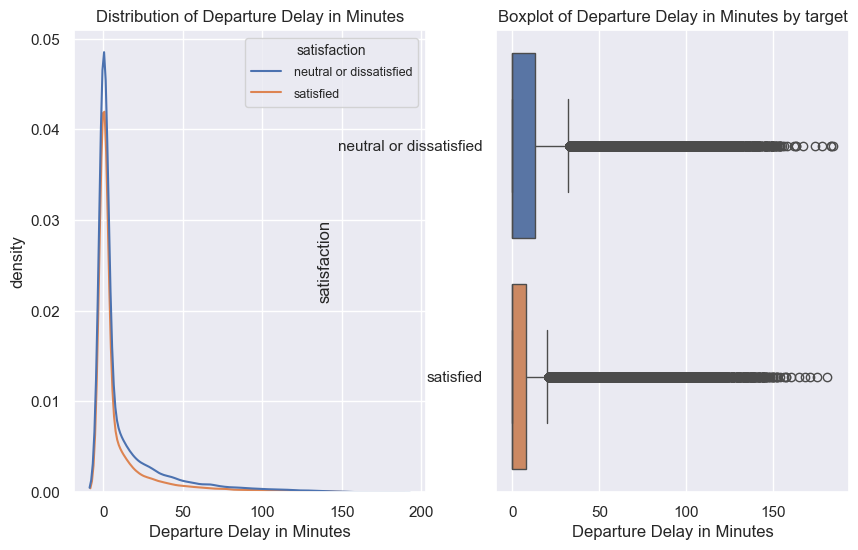

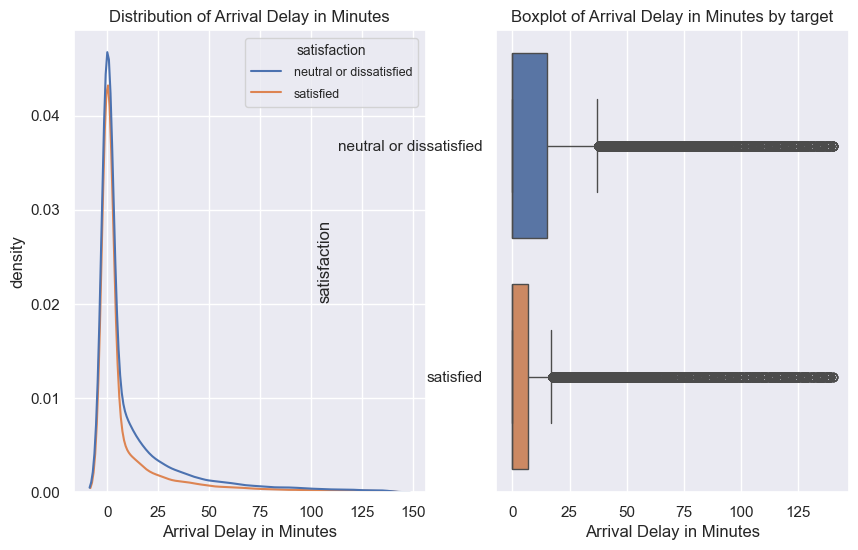

In [115]:
plot_continuous(continuous_cols, X_train, y_train)

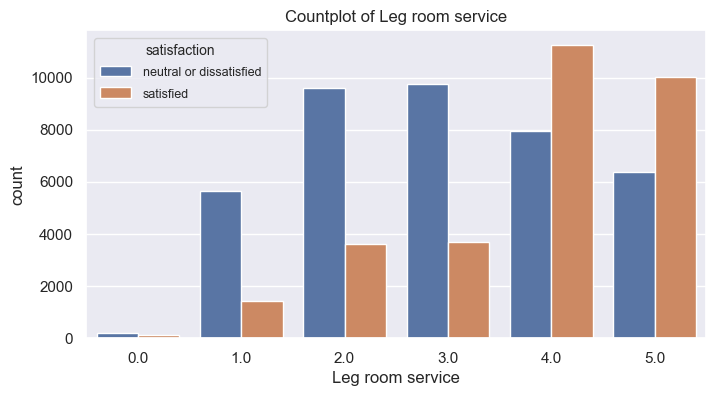

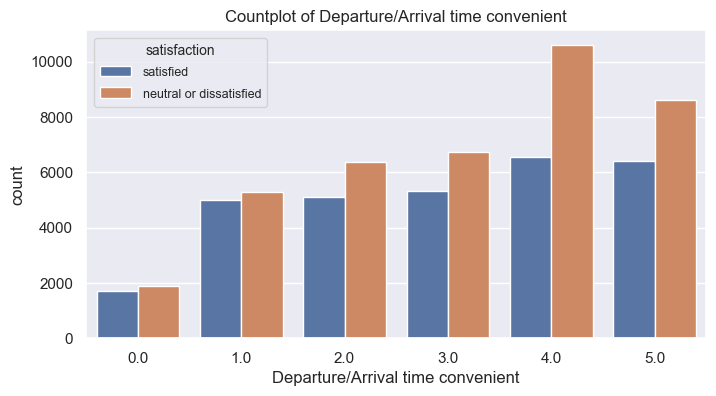

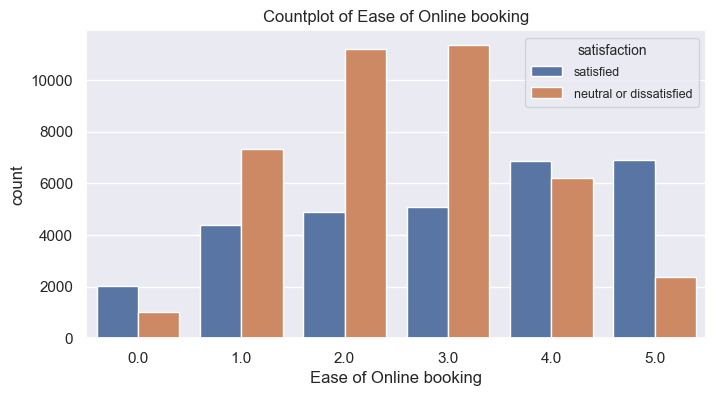

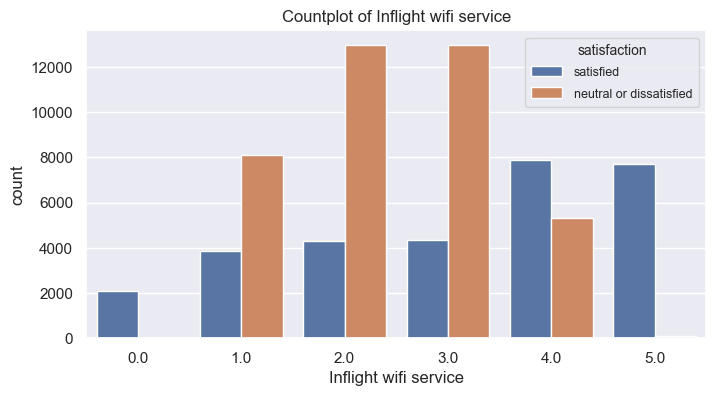

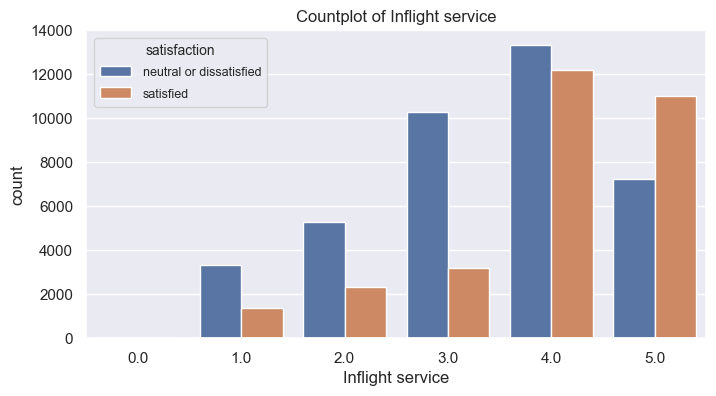

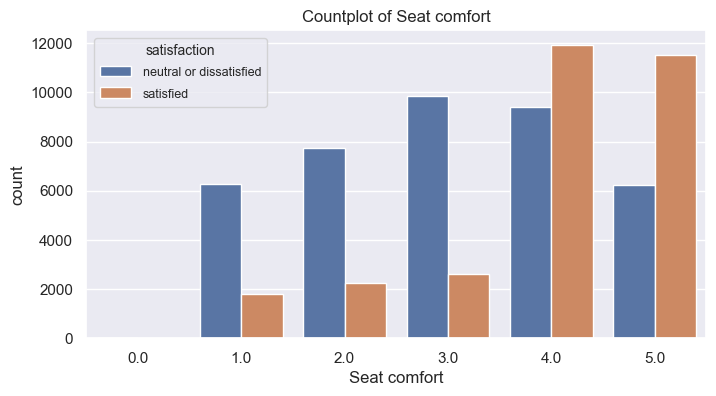

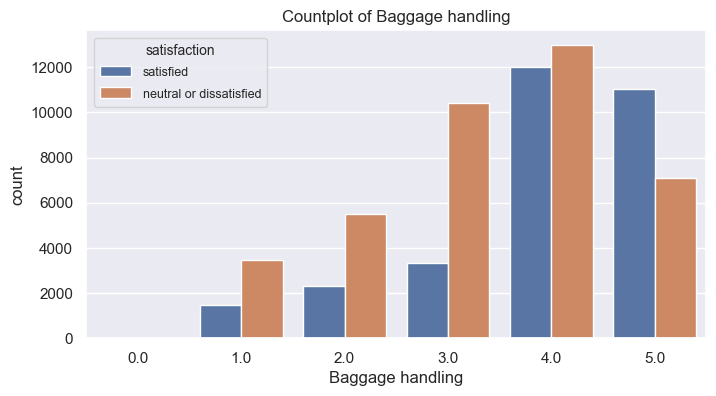

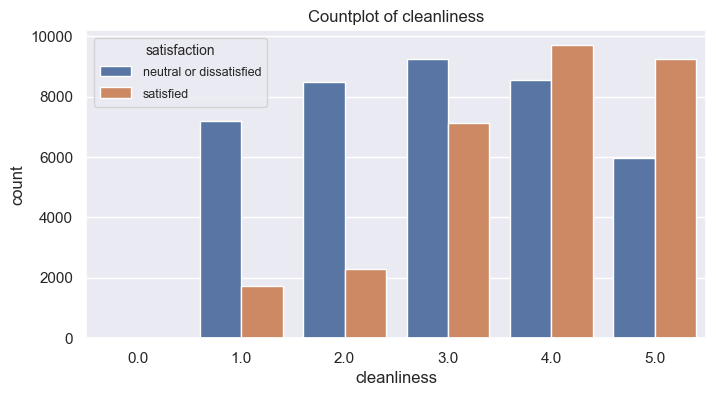

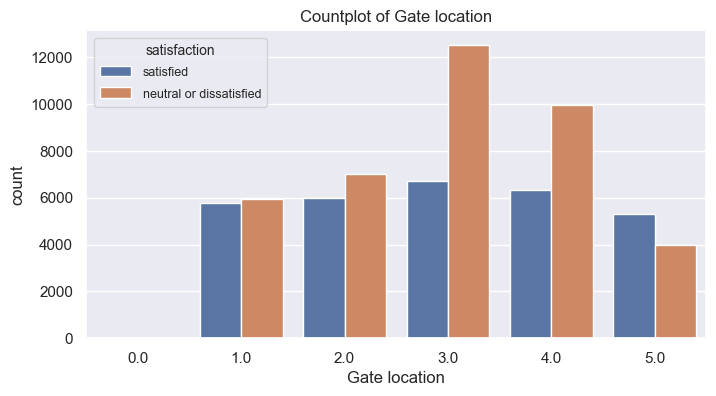

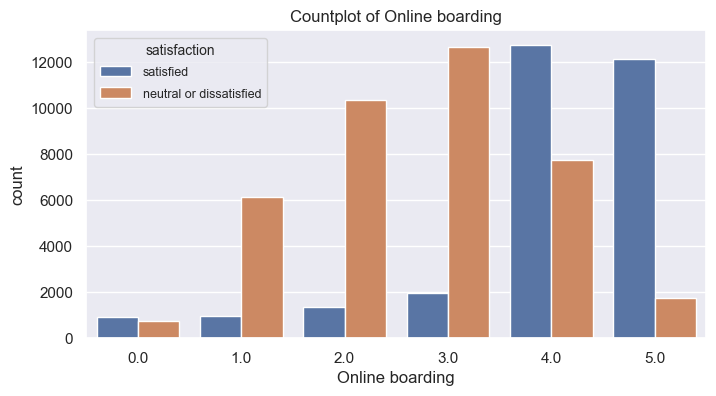

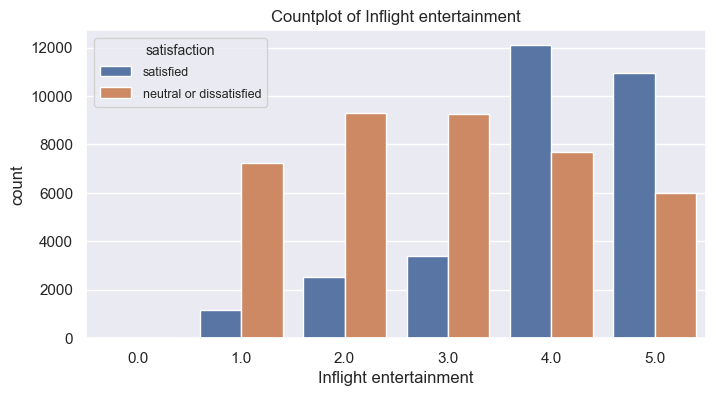

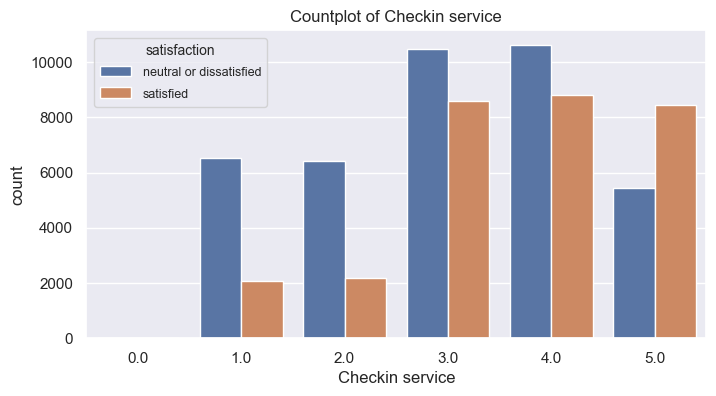

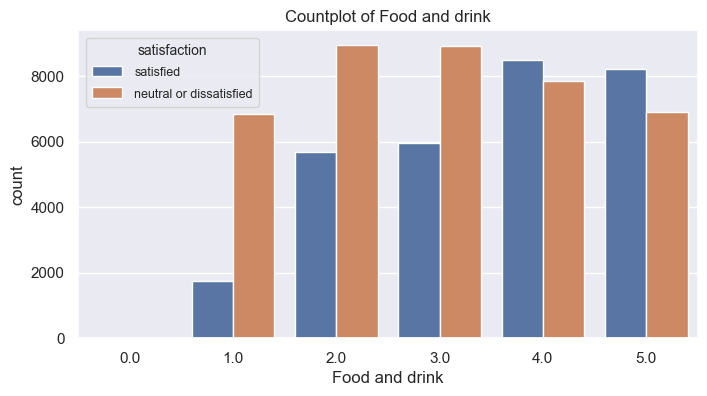

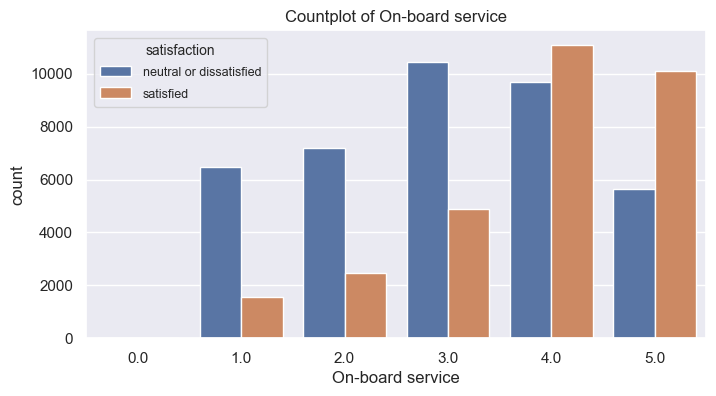

In [116]:
plot_ordinal(ordinal_cols, X_train, y_train)

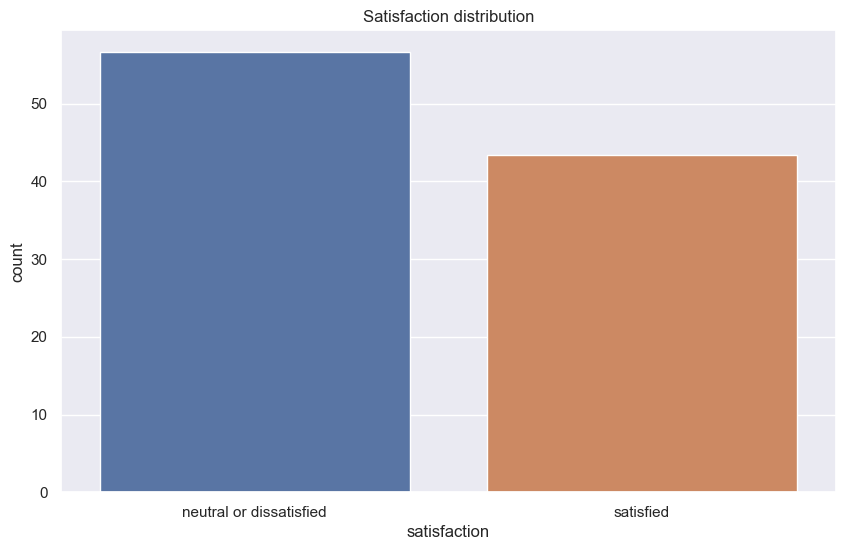

In [123]:
# visualize y_train

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.countplot(pd.DataFrame(y_train), x="satisfaction", hue="satisfaction", ax=ax, stat="percent")
ax.set_xlabel("satisfaction")
ax.set_ylabel("count")
ax.set_title("Satisfaction distribution")
plt.show()

<font color='#FF6600'>Сделайте выводы по построенным графикам</font>. Полезно было бы упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки

1. Классы нормально сбаллансированы (не 50 на 50 конечно, но для реальных данных - это достаточно). 
2. Признаки Departure Delay in Minutes и Arraival Delay in Minutes распределены неравномерно, большая часть значений лежит в одной части.
3. Явно можно сказать, что есть зависимость между Inflight Service, On-board Service, Checkin Service, Leg-room Service, Seat comfort & cleaniness и traget'ом, так как чем меньше значение этой фичи - тем больше у нас вероятность неудовлетворенности полетом. Часть фичей - это признаки "вне самолета" - сервис регистрации, ожидания и после полетный сервис - те обслуживание вне самотела важно. 
4. В большинстве полетов на дальние дистанции люди остаются удовлетворенными.

(Бонус: 0.25 балла) <font color='#9933CC'>По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест </font>

In [ ]:
# your code below



(0.25 балла) Давайте <font color='#9933CC'>заменим признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.</font>

In [160]:
# your code
X_train["Departure Delay in Minutes"] = np.log1p(X_train["Departure Delay in Minutes"])
X_train["Arrival Delay in Minutes"] = np.log1p(X_train["Arrival Delay in Minutes"])

X_val["Departure Delay in Minutes"] = np.log1p(X_val["Departure Delay in Minutes"])
X_val["Arrival Delay in Minutes"] = np.log1p(X_val["Arrival Delay in Minutes"])

df_test["Departure Delay in Minutes"] = np.log1p(df_test["Departure Delay in Minutes"])
df_test["Arrival Delay in Minutes"] = np.log1p(df_test["Arrival Delay in Minutes"])

Теперь заново <font color='#9933CC'>постройте графики континуальных признаков</font>

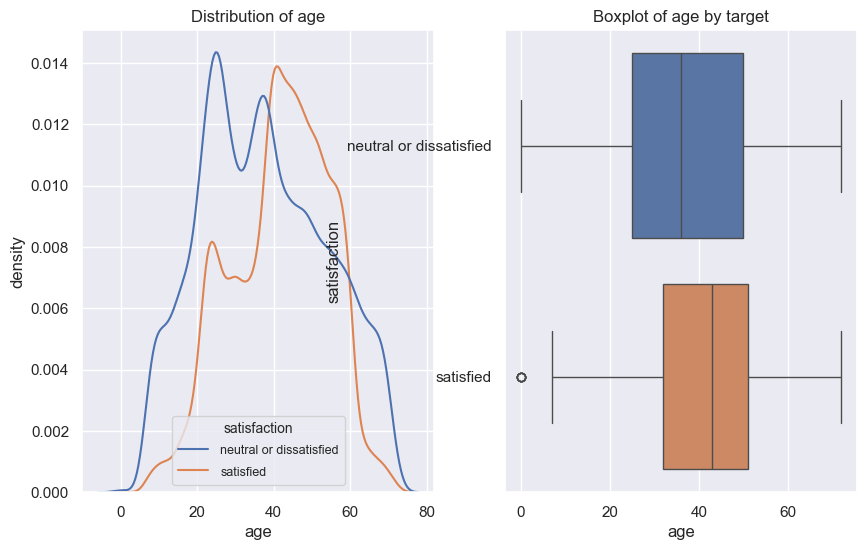

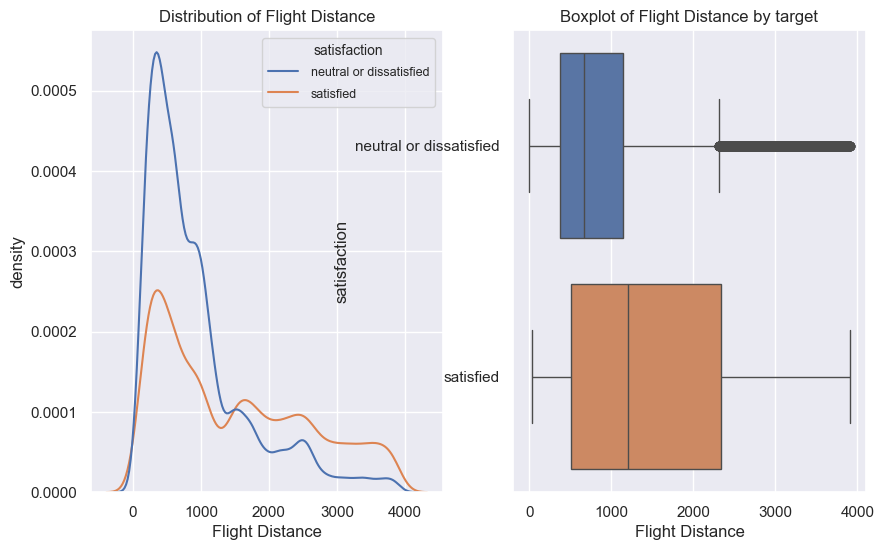

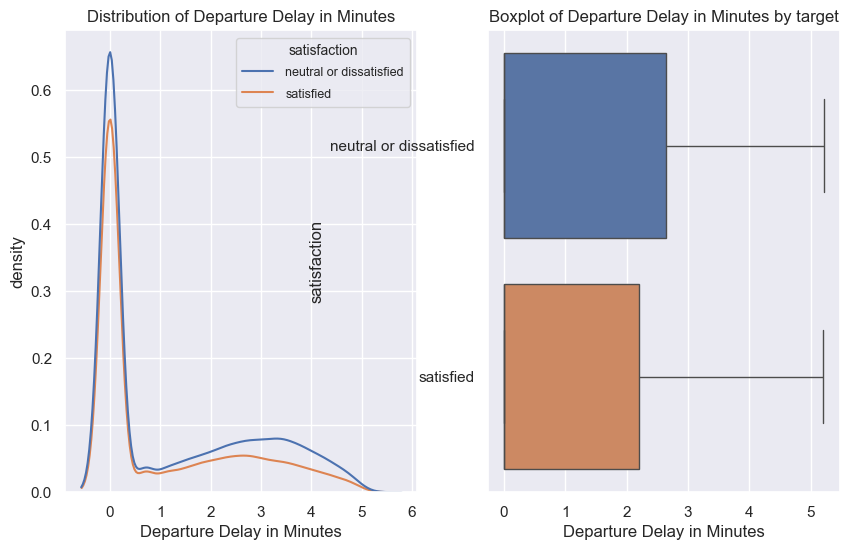

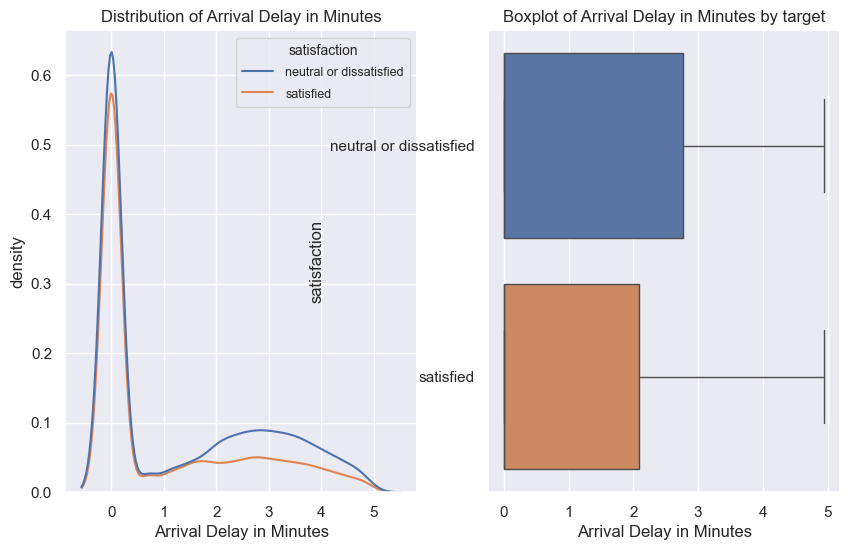

In [130]:
plot_continuous(continuous_cols, X_train, y_train)

<font color='#9933CC'>Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0</font>

In [161]:
# your code
y_train = y_train.apply(lambda x: 1 if x=="satisfied" else 0)
y_val = y_val.apply(lambda x: 1 if x=="satisfied" else 0)

(0.25 балла) <font color='#9933CC'>Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом</font>. Наблюдений много, так что отрисовка графика вполне может занять несколько минут

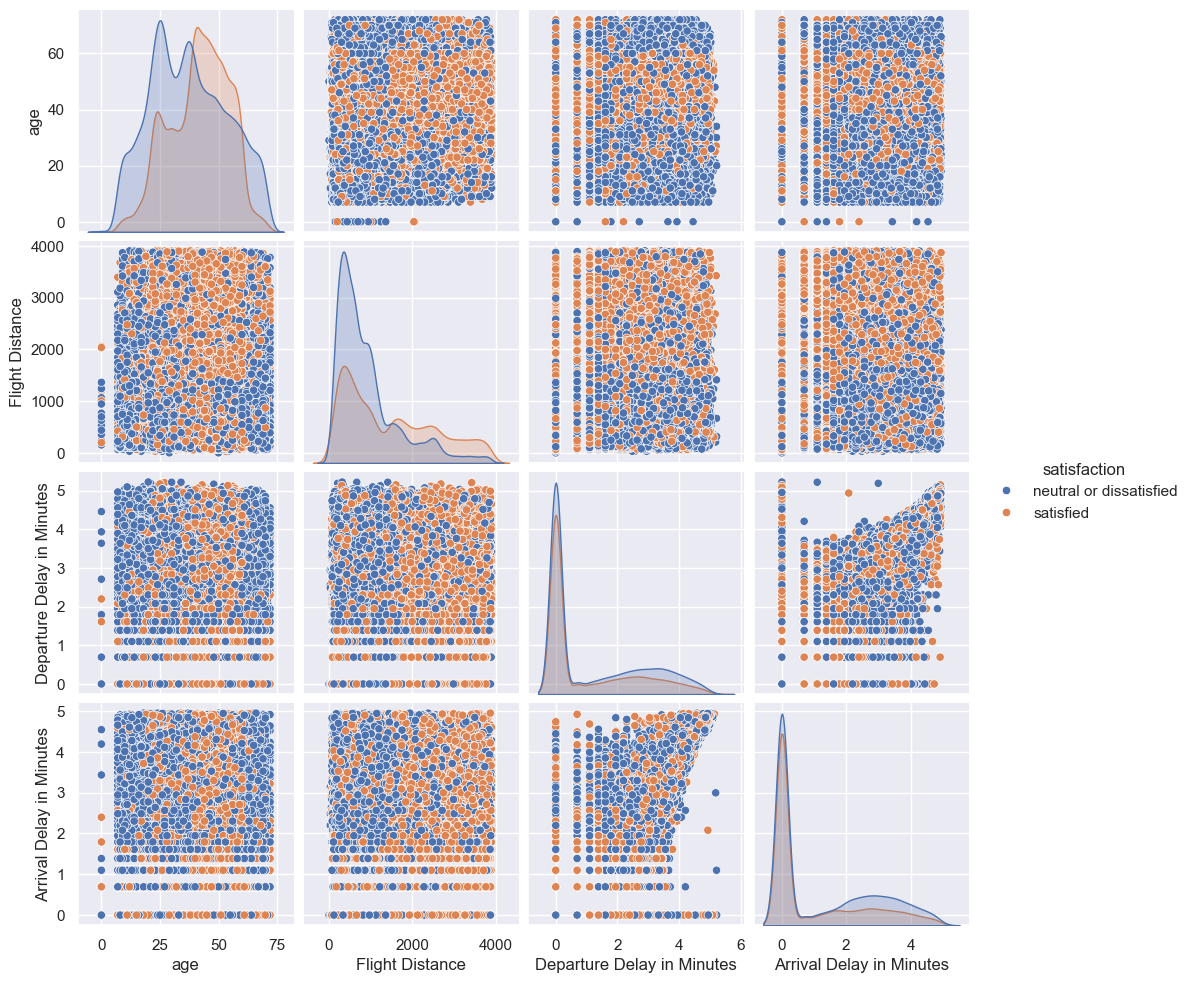

In [142]:
df_pairlot = X_train[continuous_cols].merge(y_train.apply(lambda x: "satisfied" if x==1 else "neutral or dissatisfied"), on="id", how="inner")
sns.pairplot(df_pairlot, hue="satisfaction")
plt.show()

# Decision Tree (3 балла)

(0.5 балла) <font color='#9933CC'>Закодируйте категориальные признаки методом OHE</font>. Для дерева используйте гиперпараметры по умолчанию.

In [163]:
# your code below

OHE = OneHotEncoder()

X_train_enc = X_train.copy()
X_val_enc = X_val.copy()
df_test_enc = df_test.copy()

X_train_ohe = OHE.fit_transform(X_train[categorical_cols]).toarray()
X_val_ohe = OHE.transform(X_val[categorical_cols]).toarray()
df_test_ohe = OHE.transform(df_test[categorical_cols]).toarray()

X_train_enc.drop(categorical_cols, axis=1, inplace=True)
X_val_enc.drop(categorical_cols, axis=1, inplace=True)
df_test_enc.drop(categorical_cols, axis=1, inplace=True)

new_cat_features = OHE.get_feature_names_out(input_features=categorical_cols)

X_train_enc[new_cat_features] = X_train_ohe
X_val_enc[new_cat_features] = X_val_ohe
df_test_enc[new_cat_features] = df_test_ohe

<font color='#9933CC'>Обучите дерево решений с параметрами по умолчанию на имеющихся данных.</font> Здесь и далее везде, где вас просят что-нибудь обучить, выводите `accuracy_score` для валидационной подвыборки

In [209]:
# code here
clf = DecisionTreeClassifier()
clf.fit(X_train_enc, y_train[X_train_enc.index])
y_pred = clf.predict(X_val_enc)

print(f"DecisionTreeClassifier accuracy_score: {accuracy_score(y_val[X_val_enc.index], y_pred)}")

DecisionTreeClassifier accuracy_score: 0.9451405919306615


## Деревья решений. Теоретическая вставка

(0.5 балла) <font color='#9933CC'>Посчитайте bias и variance для построенного дерева.</font> Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [185]:
# change *params into what needs to be there by task condition
params = {
    "estimator": clf,
    "loss": "0-1_loss",
    "X_train": X_train_enc.values,
    "X_test": X_val_enc.values,
    "y_train": y_train[X_train_enc.index].values,
    "y_test": y_val[X_val_enc.index].values,
    "random_seed": 42
    }


error_dt, bias_dt, var_dt = bias_variance_decomp(**params)
error_dt, bias_dt, var_dt

(0.05889222965028388, 0.03933886518628011, 0.043523196828702926)

## Возвращение к задаче

(0.5 балла) <font color='#9933CC'>Выведите на экран barplot, демонстрирующий оценки важности признаков</font>

[]

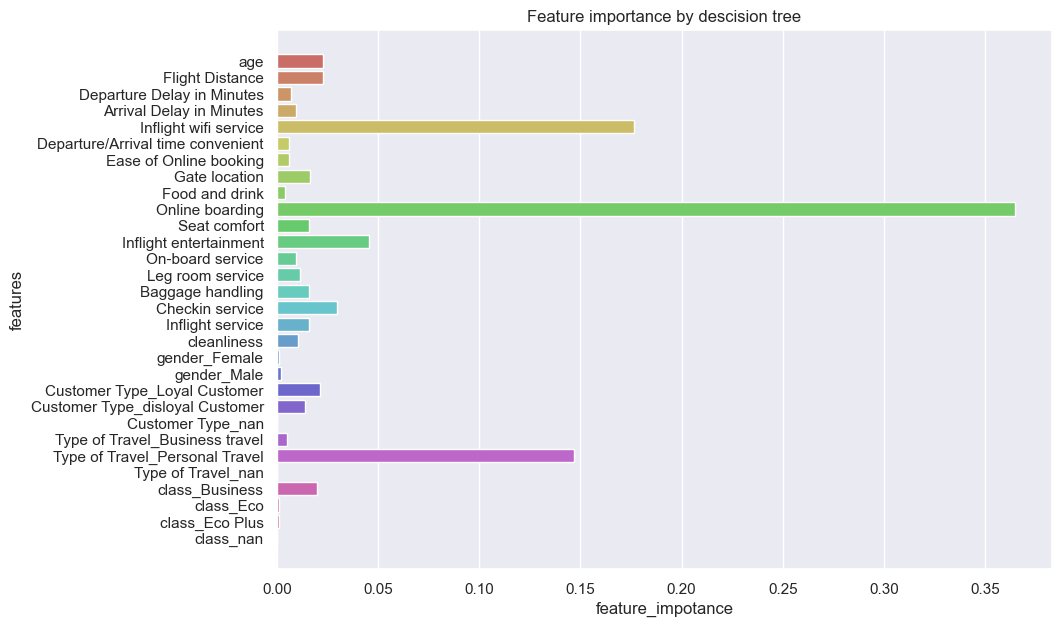

In [218]:
barplot_data = pd.DataFrame({
    "feature_impotance": clf.feature_importances_.tolist(),
    "features": X_train_enc.columns.tolist()
})
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.barplot(barplot_data, x="feature_impotance", y="features", hue="features", orient="h", palette=sns.color_palette("hls", 30), ax=ax)
ax.set_title("Feature importance by descision tree")
plt.plot()

<font color='#FF6600'>Какие признаки оказались наиболее информативными?</font>

Самые информативные: `Online boarding`, `Inflight wifi service`, `Type of Travel_Personal Travel`

<font color='#9933CC'>Какой глубины получилось дерево? Сколько в нем листьев?</font>

In [221]:
print(f"Получилось дерево глубиной {clf.get_depth()}, в нем {clf.get_n_leaves()} листьев.")

Получилось дерево глубиной 34, в нем 2782 листьев.


<font color='#9933CC'>Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева</font>. <font color='#FF6600'>Насколько упало качество на тесте?</font>

In [222]:
# the place for your solution
# code here
most_info_cols = ["Online boarding", "Inflight wifi service"]

clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train_enc[most_info_cols], y_train[X_train_enc.index])
y_pred = clf.predict(X_val_enc[most_info_cols])

print(f"DecisionTreeClassifier accuracy_score: {accuracy_score(y_val[X_val_enc.index], y_pred)}")

DecisionTreeClassifier accuracy_score: 0.8267880538851748


Качество упало на 0.119

(0.25 балла) <font color='#9933CC'>С помощью graphviz постройте получившееся дерево решений</font>. <font color='#FF6600'>Почему предикаты в нем не целые, а кратны 1/2?</font>

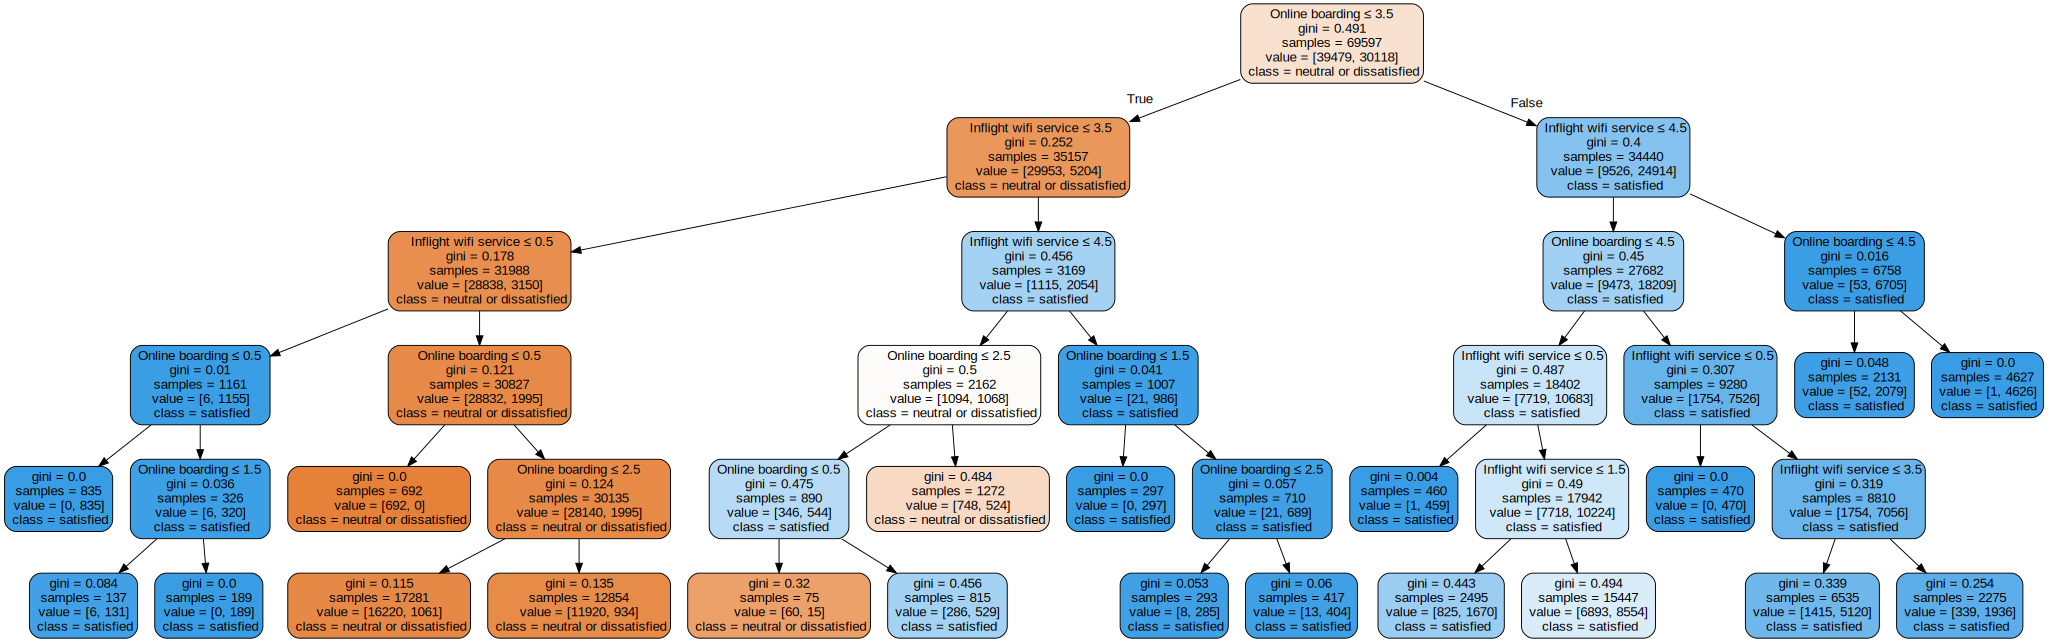

In [234]:
dot_data = export_graphviz(clf, 
                  feature_names=most_info_cols,  
                  class_names=['neutral or dissatisfied', 'satisfied'],  
                  filled=True, rounded=True,  
                  special_characters=True,
                   out_file=None,
                           )
graph = Source(dot_data)
graph

<font color='#9933CC'>Теперь постройте дерево той же глубины 5 для 2-х наиболее информативных континуальных (по договорённости) признаков</font>

In [238]:
# your code below
most_info_cols_cont = ["Flight Distance", "age"]

clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train_enc[most_info_cols_cont], y_train[X_train_enc.index])
y_pred = clf.predict(X_val_enc[most_info_cols_cont])

print(f"DecisionTreeClassifier accuracy_score: {accuracy_score(y_val[X_val_enc.index], y_pred)}")

DecisionTreeClassifier accuracy_score: 0.6821312191352841


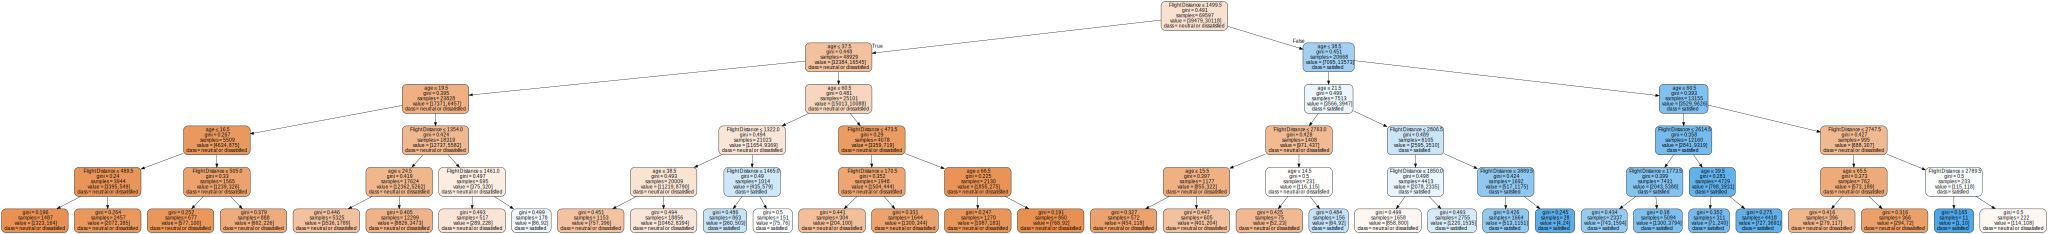

In [239]:
dot_data = export_graphviz(clf, 
                  feature_names=most_info_cols_cont,  
                  class_names=['neutral or dissatisfied', 'satisfied'],  
                  filled=True, rounded=True,  
                  special_characters=True,
                   out_file=None,
                           )
graph = Source(dot_data)
graph

(0.25 балла) <font color='#9933CC'>Отобразите его функцией `plot_tree()` из sklearn</font>. <font color='#FF6600'>Симметричным ли получилось дерево? Это хорошо или плохо?</font>

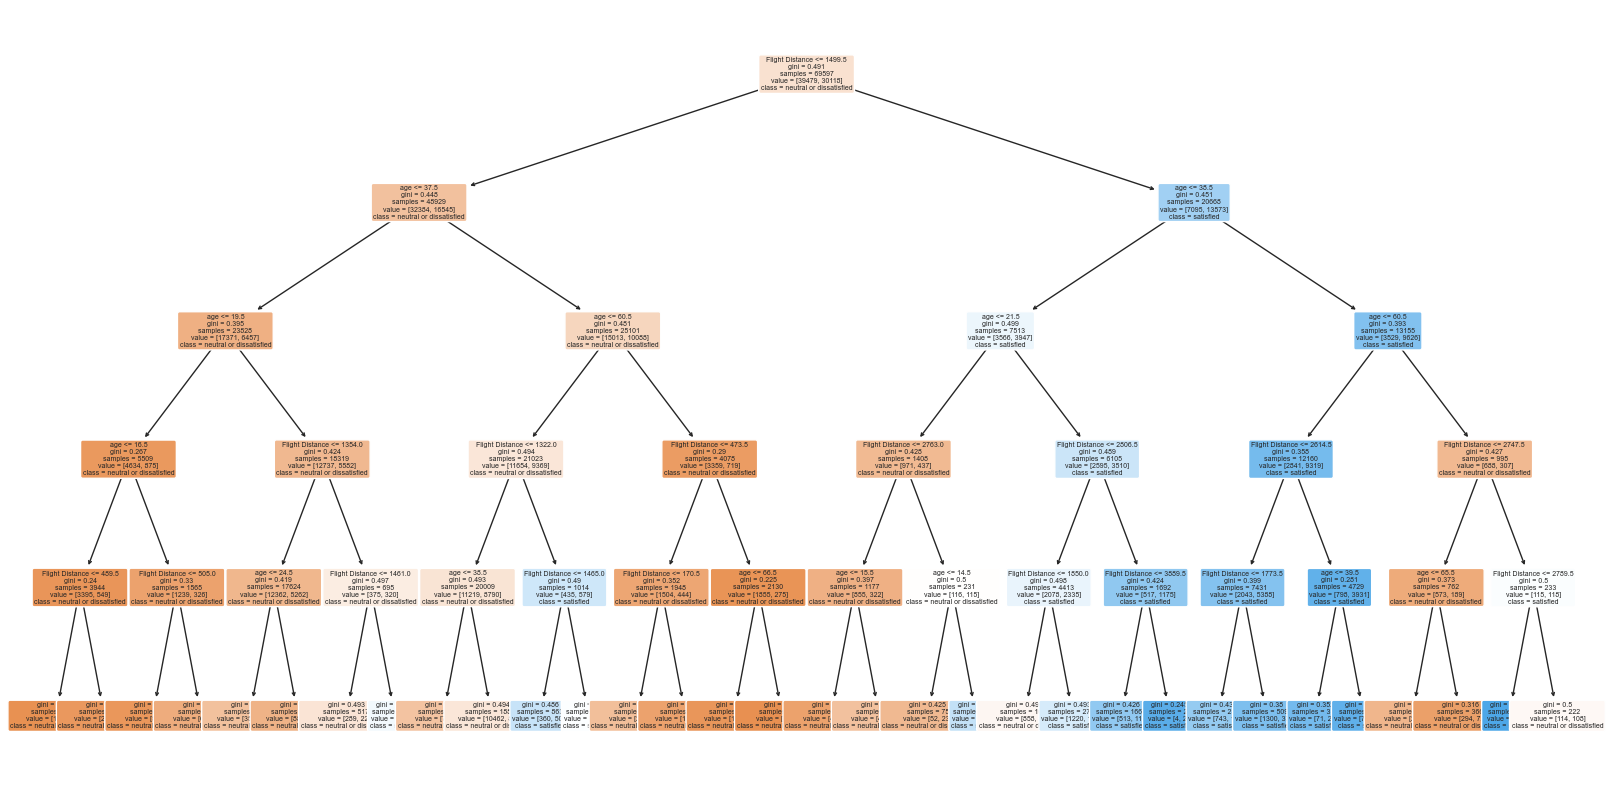

In [245]:
# another place to code a few lines
plt.figure(figsize=(20, 10))
plot_tree(decision_tree=clf, 
          feature_names=most_info_cols_cont, 
          class_names=['neutral or dissatisfied', 'satisfied'], 
          filled=True, rounded=True, fontsize=5)
plt.show()

Дерево получилось симметричным. Хорошо это или плохо - нельзя дать однозначного ответа. Если рассматривать этот вопрос с точки зрения применения решающего дерева в алгоритмах бустинга, то разные бустинги используют разные деревья. Например, `catboost` использует симметричные деревья, и их использования они объясняют следующими плюсами (https://catboost.ai/news/catboost-enables-fast-gradient-boosting-on-decision-trees-using-gpus): 
1. Simple fitting scheme
2. Efficient to implement on CPU
3. Ability to make very fast model appliers
4. This tree structure works as a regularization, so it can provide quality benefits for many tasks

В тоже время `xgboost` использует несимметричные деревья, и несимметричность сплитования в их алгоритме также помогает ускорять расчеты (не нашел тут статьи определенной).

(0.5 балла) <font color='#9933CC'>Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева.</font> Отметьте на графике только первые 100 объектов обучающей выборки

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


<Axes: >

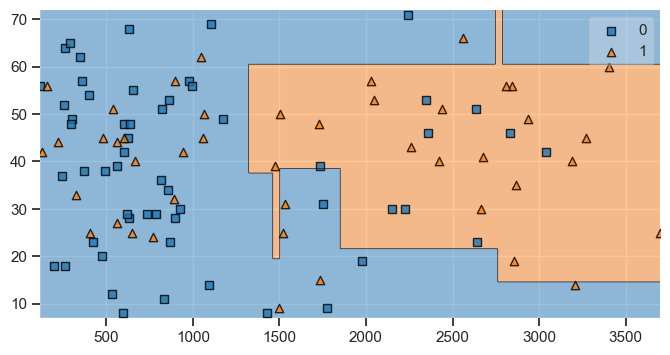

In [263]:
plot_decision_regions(
    X=X_train_enc[most_info_cols_cont][:100].values, 
    y=y_train[X_train_enc[:100].index].values, 
    clf=clf,
    )

## Деревья решений. Теоретическая вставка 2

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


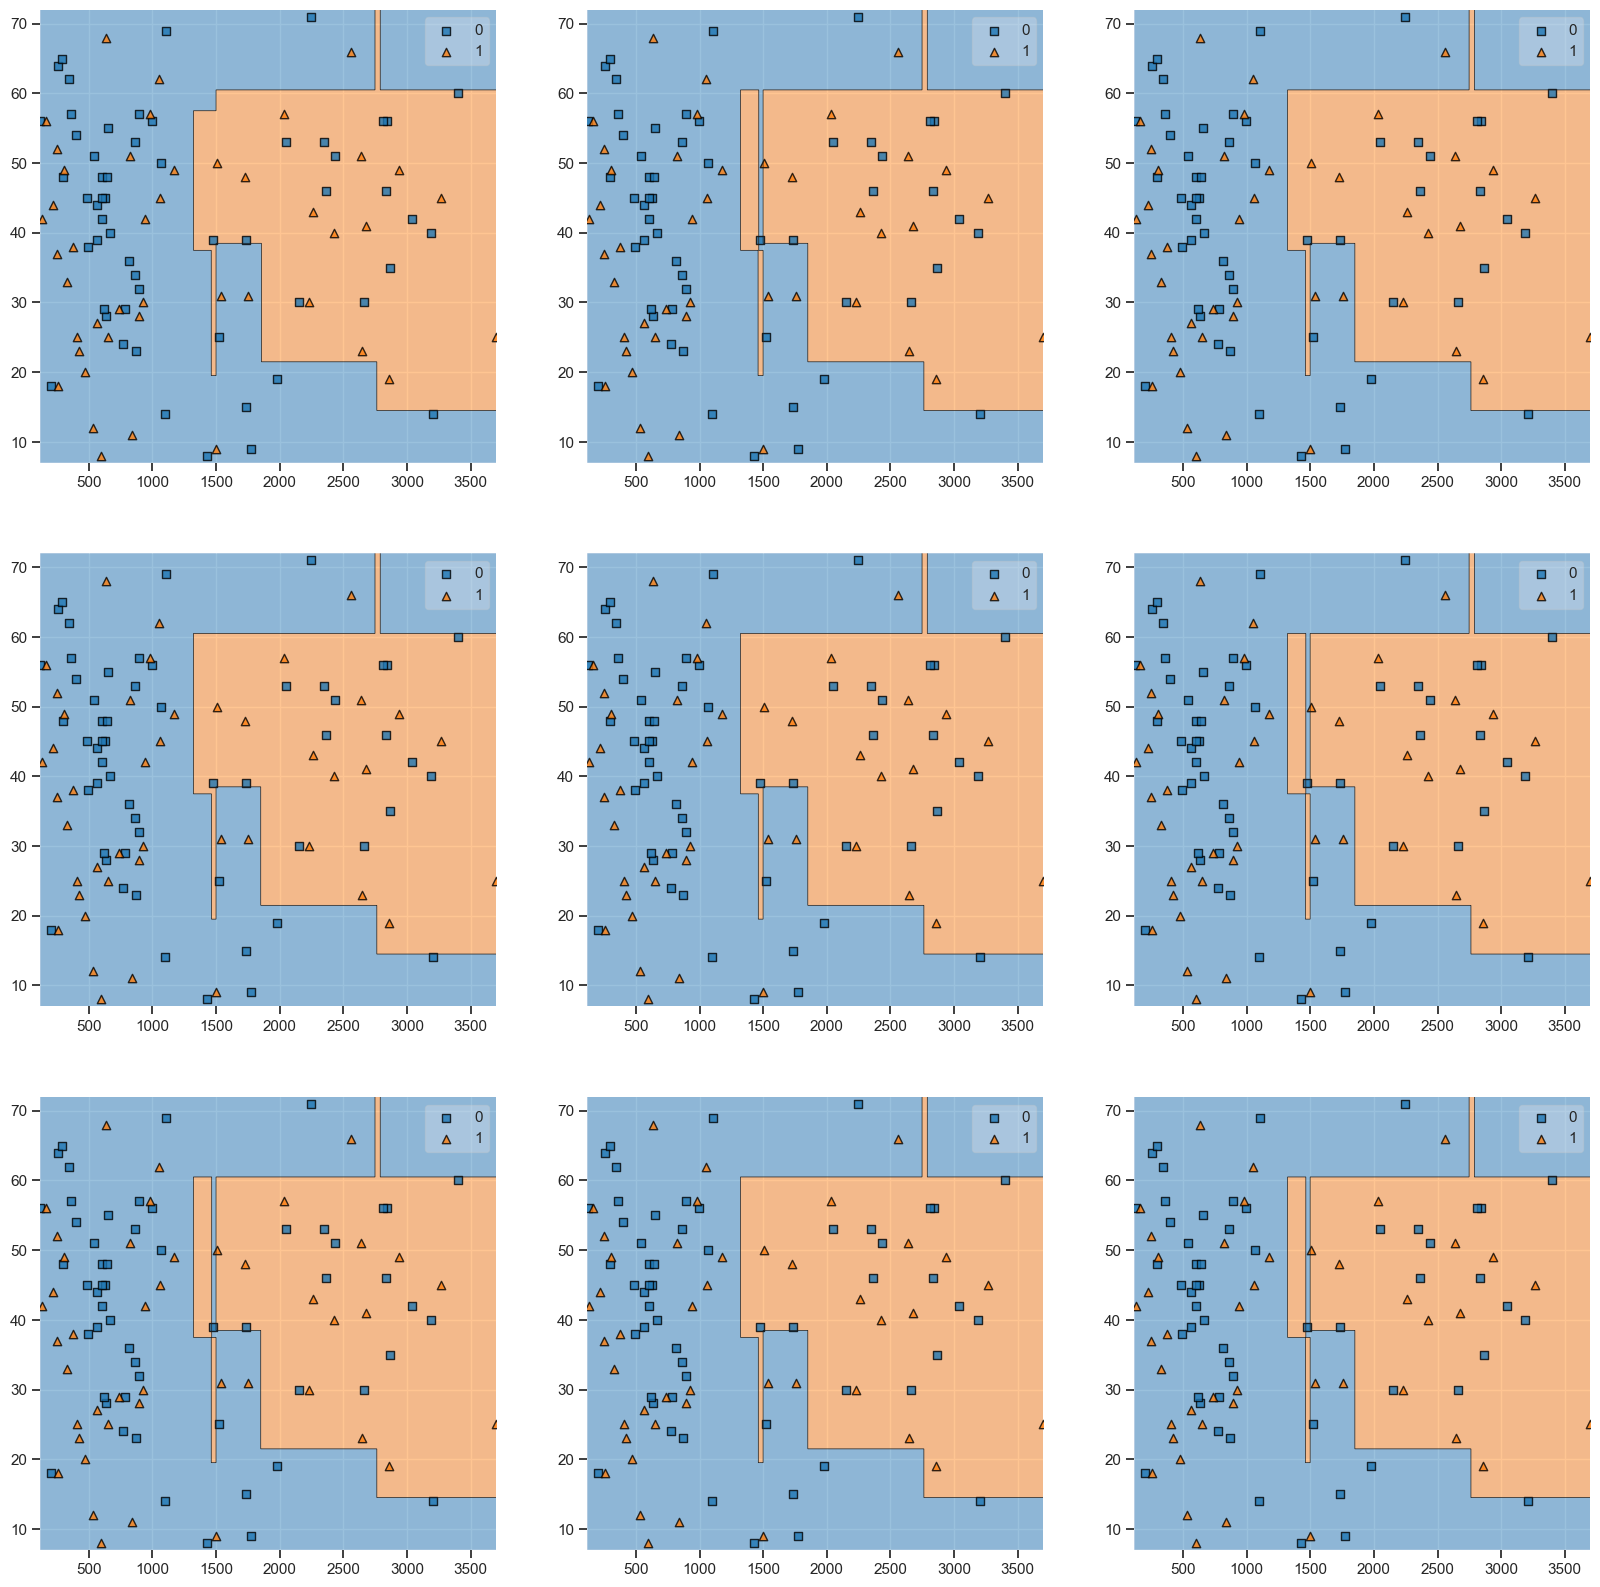

In [265]:
# change X_train_example to your equivalent

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train_enc[most_info_cols_cont].index, size=X_train_enc[most_info_cols_cont].shape[0] - 1000, replace=False) # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train_enc[most_info_cols_cont].loc[inds, :], y_train[inds])

        plot_decision_regions(clf=tree_exp, X=np.array(X_train_enc[most_info_cols_cont].iloc[:100, :]), y=np.array(y_train[:100]), ax=ax[row][col])

Мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [270]:
%%time 

depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train_enc, y_train[X_train_enc.index])
    y_predicted_train = DT.predict(X_train_enc)
    y_predicted_val = DT.predict(X_val_enc)
    accuracies_train.append(accuracy_score(y_train[X_train_enc.index], y_predicted_train))
    accuracies_test.append(accuracy_score(y_val[X_val_enc.index], y_predicted_val))

CPU times: user 2.91 s, sys: 67.5 ms, total: 2.98 s
Wall time: 2.99 s


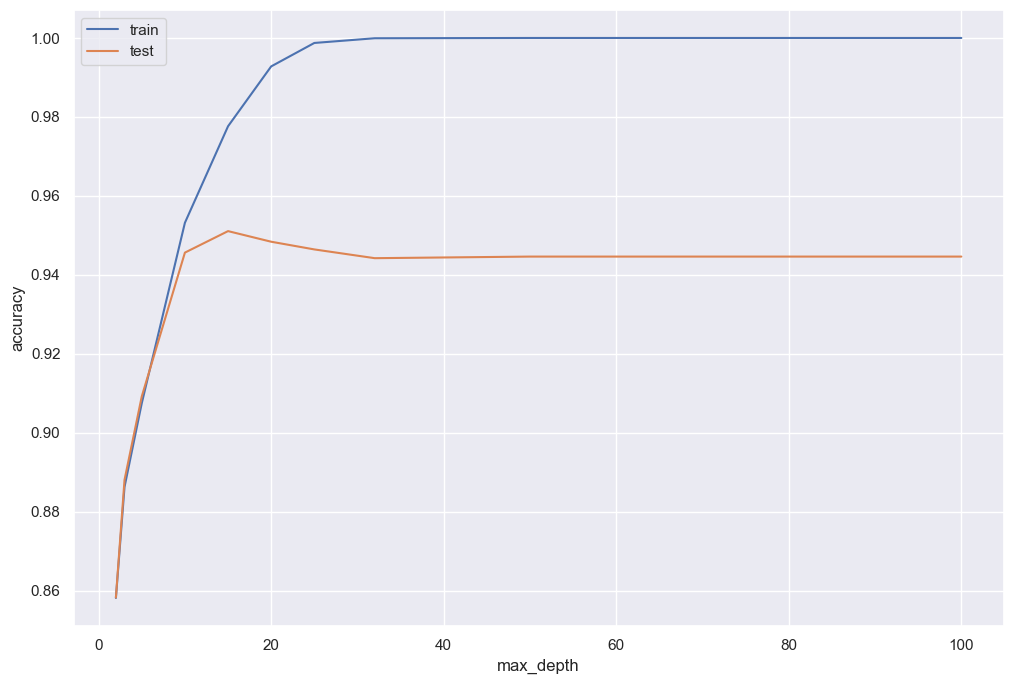

In [271]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## Возвращение к задаче

(0.5 балла) <font color='#9933CC'>На кроссвалидации подберите оптимальные гиперпараметры для дерева решений</font> *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*. <font color='#FF6600'>Удалось ли улучшить качество предсказаний подбором гиперпараметров?</font>

In [292]:
# you know what to do
params = {
    "max_depth": range(3, 25),
    "criterion": ["gini", "entropy", "log_loss"],
    "min_samples_leaf": range(1, 4)
}
cv = StratifiedKFold(n_splits=5)
clf_grid = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42), 
    param_grid=params, 
    cv=cv,
    n_jobs=10,
    )

In [293]:
clf_grid.fit(X_train_enc, y_train[X_train_enc.index])

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(random_state=42), n_jobs=10,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': range(3, 25),
                         'min_samples_leaf': range(1, 4)})

In [294]:
clf_grid.best_params_

{'criterion': 'gini', 'max_depth': 13, 'min_samples_leaf': 3}

In [295]:
y_pred = clf_grid.best_estimator_.predict(X_val_enc)

print(f"DecisionTreeClassifier accuracy_score: {accuracy_score(y_val[X_val_enc.index], y_pred)}")

DecisionTreeClassifier accuracy_score: 0.9513555279336178


<font color='#9933CC'> Сохраните лучшее дерево в pickle </font>

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [296]:
pickle.dump(clf_grid.best_estimator_, open('DT.pkl', 'wb'))

# Random Forest (4 балла)

<font color='#9933CC'>Обучите случайный лес с параметрами по умолчанию</font>

In [297]:
# -__-
RF = RandomForestClassifier()
RF.fit(X_train_enc, y_train[X_train_enc.index])

y_pred = RF.predict(X_val_enc)

print(f"RandomForestClassifier accuracy_score: {accuracy_score(y_val[X_val_enc.index], y_pred)}")

RandomForestClassifier accuracy_score: 0.9620384990089696


(0.75 балла) <font color='#9933CC'>Выведите калибровочную кривую для полученного ансамбля</font>

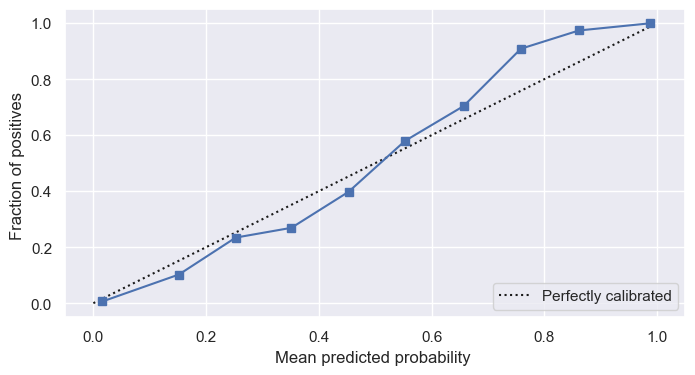

In [300]:
# some lines of your code
from sklearn.calibration import calibration_curve
y_prob = RF.predict_proba(X_val_enc)[:, 1]
prob_true, prob_pred = calibration_curve(y_val[X_val_enc.index], y_prob, n_bins=10)

disp = CalibrationDisplay(prob_true, prob_pred, y_prob)
disp.plot()

Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

<font color='#FF6600'>Вспомните (или выведите), корректно ли деревья предсказывают вероятности?</font>

В умном ответе на https://stackoverflow.com/questions/30814231/using-the-predict-proba-function-of-randomforestclassifier-in-the-safe-and-rig пишут, что деревья возвращают голос дня одного из классов, то есть для одного класса у них всегда будет вероятность 1, а для другого вероятность 0. \
Исходя из того, что RF - это ансамбль деревьев, то `predict_proba` возвращает количество голосов за тот или иной класс, деленное на общее количество деревьев. То есть это скорее частота, чем вероятность.

<font color='#9933CC'>Обучите логистическую регрессию с параметрами по умолчанию и отобразите её калибровочную кривую</font>

UPD: не с параметрами по умолчанию, а так, чтоб сошлась

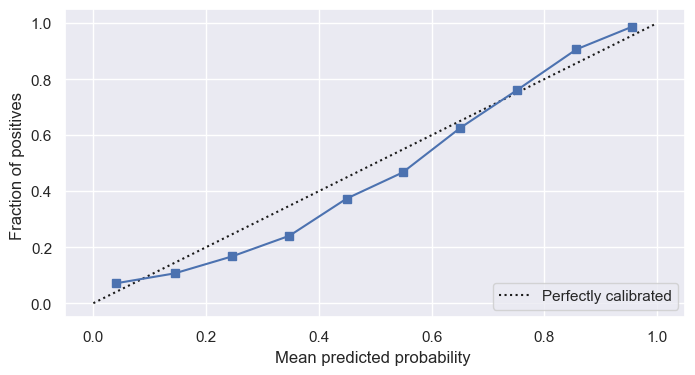

In [303]:
LR = LogisticRegression(solver="liblinear")
LR.fit(X_train_enc, y_train[X_train_enc.index])

y_prob = LR.predict_proba(X_val_enc)[:, 1]
prob_true, prob_pred = calibration_curve(y_val[X_val_enc.index], y_prob, n_bins=10)

disp = CalibrationDisplay(prob_true, prob_pred, y_prob)
disp.plot()

Мы немного переоцениваем предсказанные низкие вероятности

<font color='#FF6600'>Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?</font>

У ЛогРега при предсказании вероятности принадлежности класса применяется функция сигмоиды, которая математически используется для предсказания максимального правдоподобия. Поэтому вероятность логрега сильно близка к реальной вероятности события пренадлежности к классу.

(0.75 балла) <font color='#9933CC'>Предлагаем вам попробовать откалибровать вероятности обученного случайного леса</font>. Для этого воспользуйтесь логистической и изотонической регрессиями. <font color='#FF6600'>Интерпретируйте полученные результаты</font>

In [309]:
from sklearn.calibration import CalibratedClassifierCV

RF = RandomForestClassifier()
RF_sigmoid = CalibratedClassifierCV(estimator=RF, method="sigmoid", cv=10)
RF_sigmoid.fit(X_train_enc, y_train[X_train_enc.index])

CalibratedClassifierCV(cv=10, estimator=RandomForestClassifier())

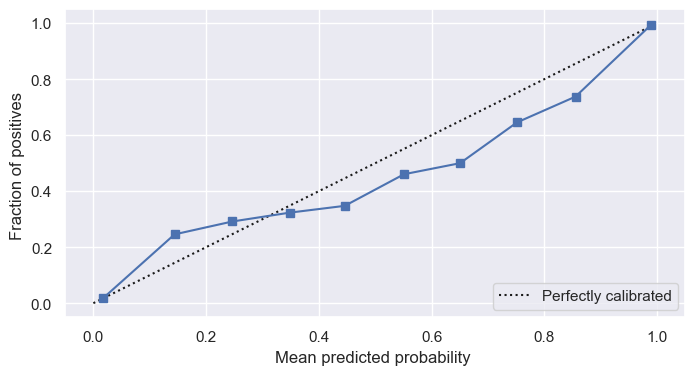

In [310]:
# yet another code cell for logreg
y_prob = RF_sigmoid.predict_proba(X_val_enc)[:, 1]
prob_true, prob_pred = calibration_curve(y_val[X_val_enc.index], y_prob, n_bins=10)

disp = CalibrationDisplay(prob_true, prob_pred, y_prob)
disp.plot()

In [312]:
RF = RandomForestClassifier()
RF_isotonic = CalibratedClassifierCV(estimator=RF, method="isotonic", cv=10)
RF_isotonic.fit(X_train_enc, y_train[X_train_enc.index])

CalibratedClassifierCV(cv=10, estimator=RandomForestClassifier(),
                       method='isotonic')

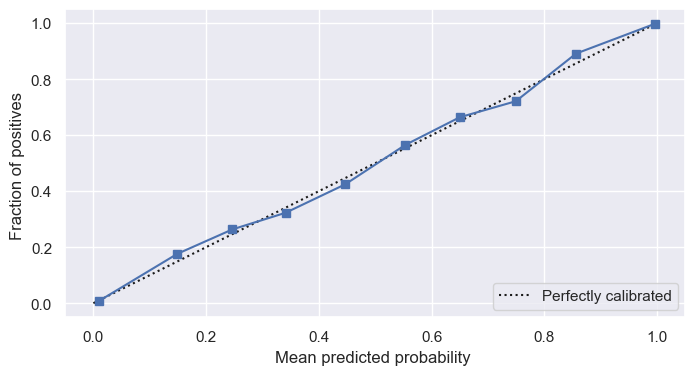

In [313]:
# yet another code cell for isoreg

y_prob = RF_isotonic.predict_proba(X_val_enc)[:, 1]
prob_true, prob_pred = calibration_curve(y_val[X_val_enc.index], y_prob, n_bins=10)

disp = CalibrationDisplay(prob_true, prob_pred, y_prob)
disp.plot()

<font color='#FF6600'>Опишите другие возвожные подходы к калбировке вероятностей (со ссылками на источники)</font>

В качестве альтернативы ЛогРега и Изотонической регрессии используется еще I-Spline колиброка. \
Подход основан на B-Spline функции, которую можно представить в виде: \
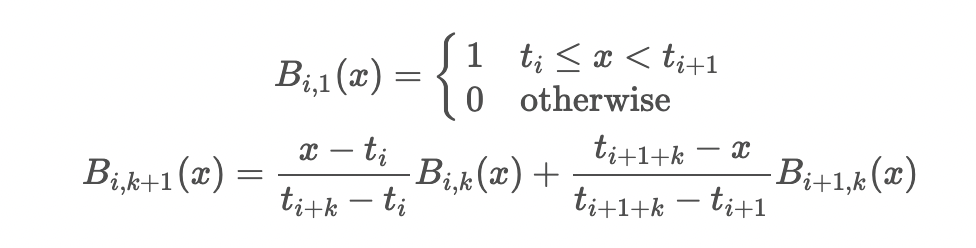 \
где k это порядок полиномиальной функции, а T=[t1,t2,…,tk] представляет собой набор неубывающих узлов, в которых кусочные полиномы соединяются. \
B-Spline - это немонотонная функция, но ее I-Spline уже монотонная. И ее подход заключается в том, что если хорошо нормализованная B-Spline функция будет принимать только положительные значения, то интеграл B-Spline будет постоянно рости. А если соединить возрастающие функции с положительными весами, мы достигнем монотонности. То есть можно: 
1. Оценить базисные функции, используя выражения замкнутой формы для I-Spline.
2. Достигаем монотонности, ограничивая наши веса положительными. На практике добиваемся этого путем оптимизации по log(βi). 
3. Оптимизировать веса, используя правильное правило оценки, такое как log-loss или MSE.
В статье, которую я читал, также представлена картинка колибковки I-Spline в сравнении с другими колибраторами: \
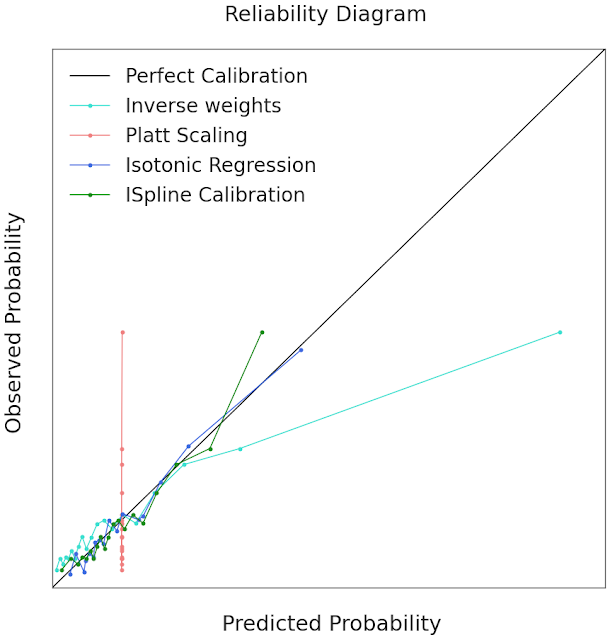 \
Source: https://www.unofficialgoogledatascience.com/2021/04/why-model-calibration-matters-and-how.html

(1 балл) <font color='#9933CC'>Посчитайте разброс и смещение полученного случайного леса (до калибровки).</font><font color='#FF6600'>Оличаются ли они от полученных для дерева решений? Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?</font>

In [314]:
# one more place for your code
params = {
    "estimator": RF,
    "loss": "0-1_loss",
    "X_train": X_train_enc.values,
    "X_test": X_val_enc.values,
    "y_train": y_train[X_train_enc.index].values,
    "y_test": y_val[X_val_enc.index].values,
    "random_seed": 42
    }


error_dt, bias_dt, var_dt = bias_variance_decomp(**params)
error_dt, bias_dt, var_dt

(0.03952144992777236, 0.03762555850438405, 0.008536802499412102)

Отличаются - значения ошибки, смещения и разброса меньше, чем у одного дерева. В теории у решающего дерева должна быть меньше дисперсия, чем у случайного леса, так как дисперсия должна быть меньше у простых моделей, и больше у сложных, таких как ансамбль деревьев. Смещение должно быть больше у решающего дерева, меньше у леса. \
На практике у нас получилось, что и смещение, и дисперсия меньше у леса. Скорее всего дерево переобучилось, поэтому мы видим такой результат. Композиция деревьев в случайном лесе приводит к меньшему переобучению. поэтому имеем меньший байес и дисперсию.

<font color='#9933CC'>Вычислите разложение ошибки для логистической регрессии (ванильной, не той, что использовали для калибровки).</font> <font color='#FF6600'>Сравните полученные результаты с предыдущими. Объясните природу этих результатов</font>

In [317]:
# (•_•)
LR = LogisticRegression(solver="liblinear")

params = {
    "estimator": LR,
    "loss": "0-1_loss",
    "X_train": X_train_enc.values,
    "X_test": X_val_enc.values,
    "y_train": y_train[X_train_enc.index].values,
    "y_test": y_val[X_val_enc.index].values,
    "random_seed": 42
    }

error_dt, bias_dt, var_dt = bias_variance_decomp(**params)
error_dt, bias_dt, var_dt

(0.12343803540833809, 0.12342526959384553, 0.0041848355561527875)

Тут получились более логичные результаты: ошибка больше, чем у RF, а дисперсия меньше, так как ЛогРег - более простая модель. Высокое смещение и низкая дисперсия - это признак того, что Логрег немного переобучился.

(1 балл) <font color='#9933CC'>Попробуйте подобрать оптимальные гиперпараметры, используя `RandomizedSearchCV`</font>. Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [355]:
# your code here
from scipy.stats import uniform
RF = RandomForestClassifier()

distributions = {
    "n_estimators": range(500, 1001),
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": range(6, 26),
    "min_samples_split": uniform.rvs(size=15),
    "min_samples_leaf": uniform.rvs(size=15),
}

cv = StratifiedKFold(n_splits=5)

RF_cv = RandomizedSearchCV(
    estimator=RF,
    param_distributions=distributions,
    n_iter=100,
    n_jobs=6,
    cv=cv,
)

In [356]:
RF_cv.fit(X_train_enc, y_train[X_train_enc.index])

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=6,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': range(6, 26),
                                        'min_samples_leaf': array([0.29436863, 0.10639566, 0.53930498, 0.86679823, 0.2477013 ,
       0.79158884, 0.3798851 , 0.53456476, 0.94162677, 0.2760809 ,
       0.30740982, 0.93918824, 0.7589505 , 0.30238835, 0.23957076]),
                                        'min_samples_split': array([0.13981454, 0.60355455, 0.93411643, 0.76758428, 0.24984555,
       0.6089273 , 0.31300057, 0.47517398, 0.47839637, 0.52134297,
       0.55153442, 0.43316886, 0.33246426, 0.84437288, 0.77570625]),
                                        'n_estimators': range(500, 1001)})

In [357]:
RF_cv.best_estimator_

RandomForestClassifier(max_depth=7, min_samples_leaf=0.10639566185161942,
                       min_samples_split=0.31300057162894535, n_estimators=518)

In [359]:
y_pred = RF_cv.best_estimator_.predict(X_val_enc)

print(f"RandomForestClassifier fitted accuracy_score: {accuracy_score(y_val[X_val_enc.index], y_pred)}")

RandomForestClassifier fitted accuracy_score: 0.8676722545100278


In [347]:
RF = RandomForestClassifier()
RF.fit(X_train_enc, y_train[X_train_enc.index])

y_pred = RF.predict(X_val_enc)

print(f"RandomForestClassifier fitted accuracy_score: {accuracy_score(y_val[X_val_enc.index], y_pred)}")

RandomForestClassifier fitted accuracy_score: 0.9621392817549635


Не очень получилось, так как я ставил 100 итераций подбора. Скорее всего, если поставить больше итераций (>=500), или запустить жадный грид серч, то подберутся более оптимальные параметры. А пока что дефолтные параметры при обучении оказались лучше, чем подобранные.

## Случайный лес. Вставка теории

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [349]:
# change X_train_enc into you equivalent

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train_enc[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train[X_train_RF.index])

    errors.append(1 - clf.oob_score_)

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


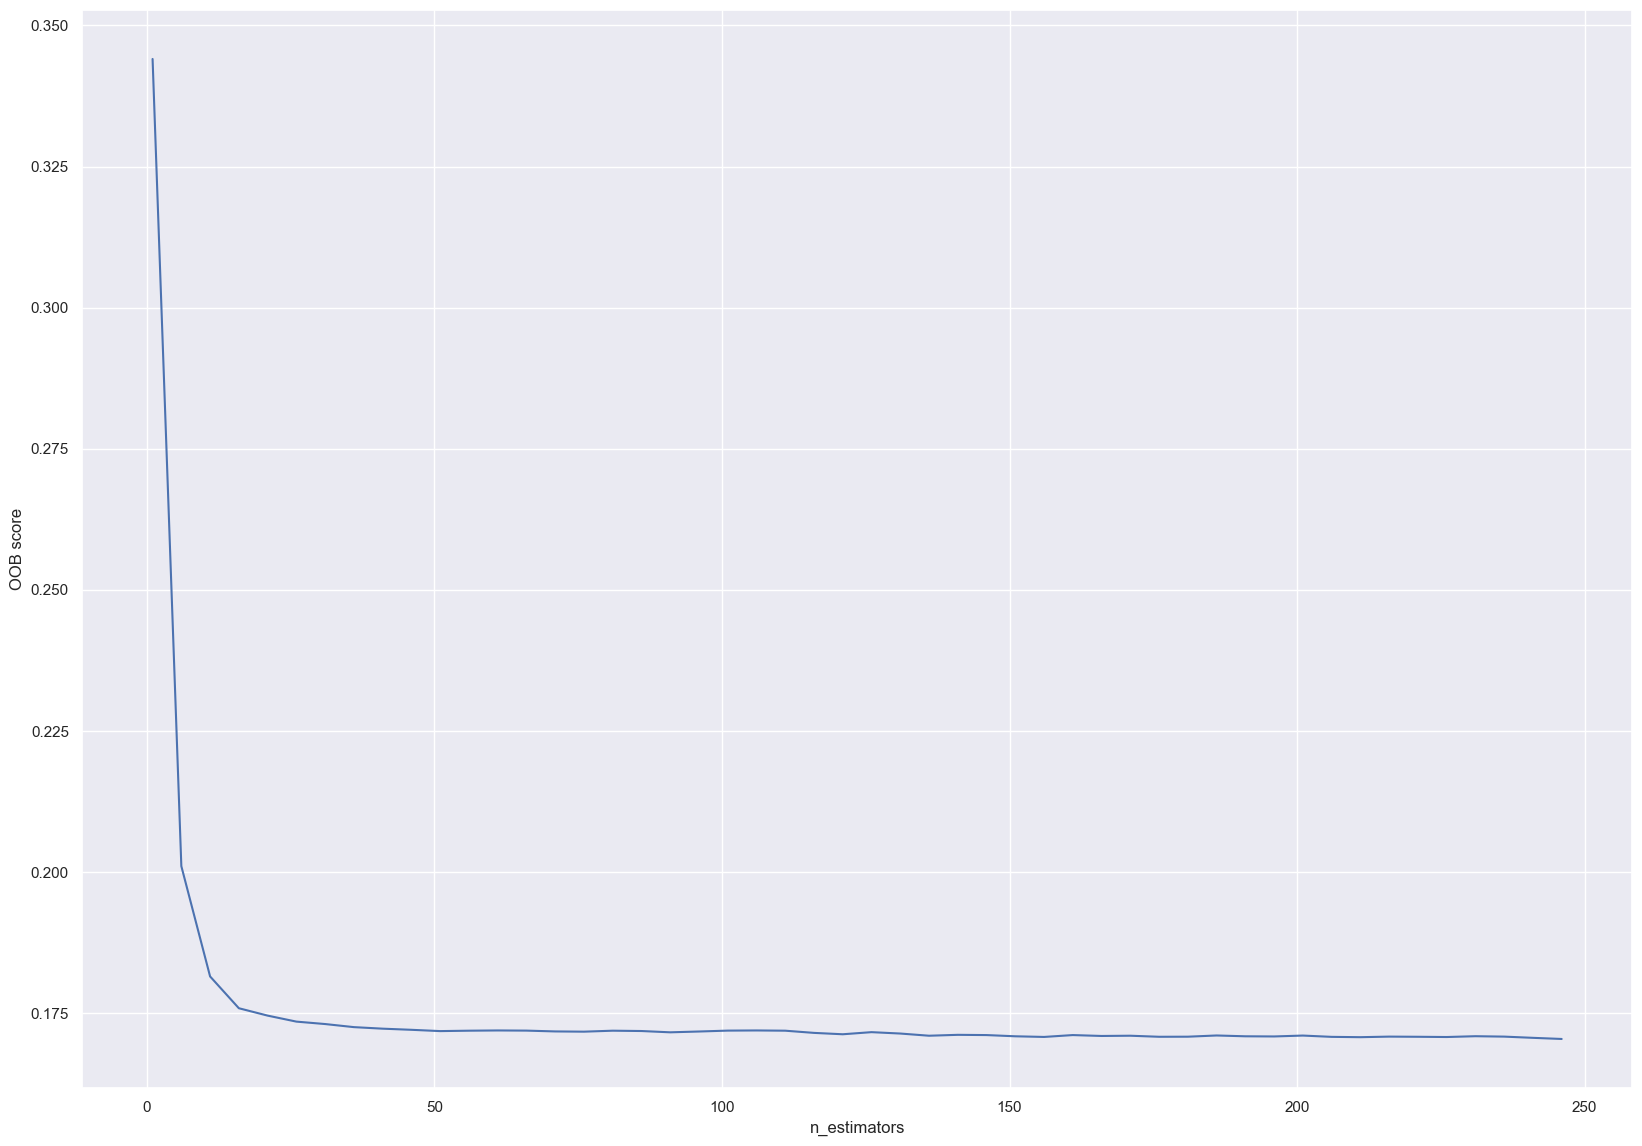

In [350]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

> **Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной 

## Возвращение к задаче

<font color='#9933CC'>Отобразите `feature_importances_` вашего лучшего случайного леса</font>

[]

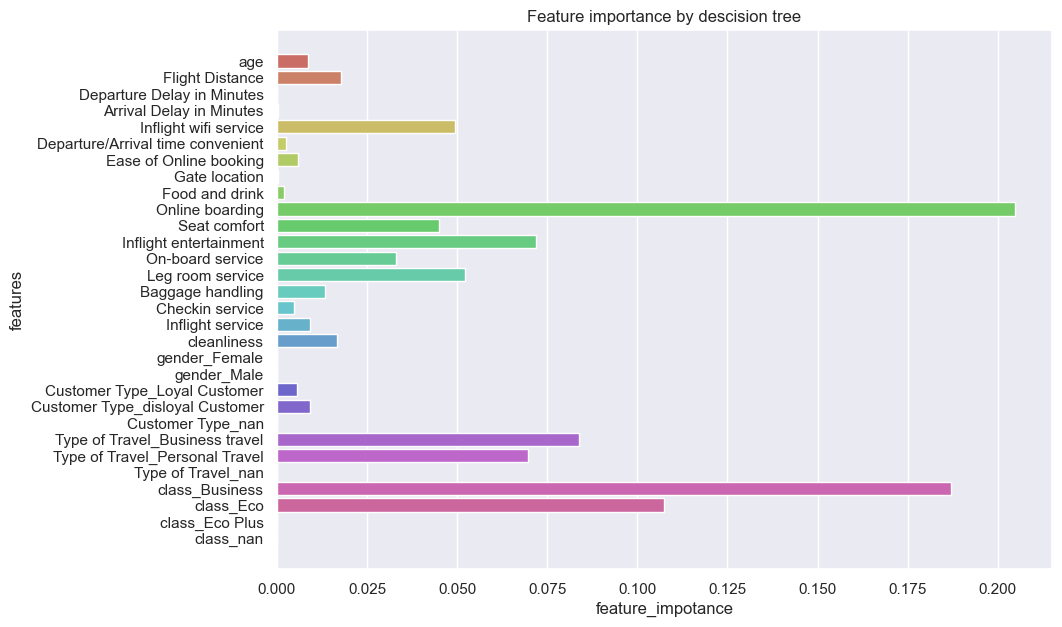

In [360]:
# (•_•)
barplot_data = pd.DataFrame({
    "feature_impotance": RF_cv.best_estimator_.feature_importances_.tolist(),
    "features": X_train_enc.columns.tolist()
})
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.barplot(barplot_data, x="feature_impotance", y="features", hue="features", orient="h", palette=sns.color_palette("hls", 30), ax=ax)
ax.set_title("Feature importance by descision tree")
plt.plot()

(0.5 балла) <font color='#9933CC'>Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму</font>

In [362]:
DT = DecisionTreeClassifier()
DT.fit(X_train_enc, y_train[X_train_enc.index])

DecisionTreeClassifier()

[]

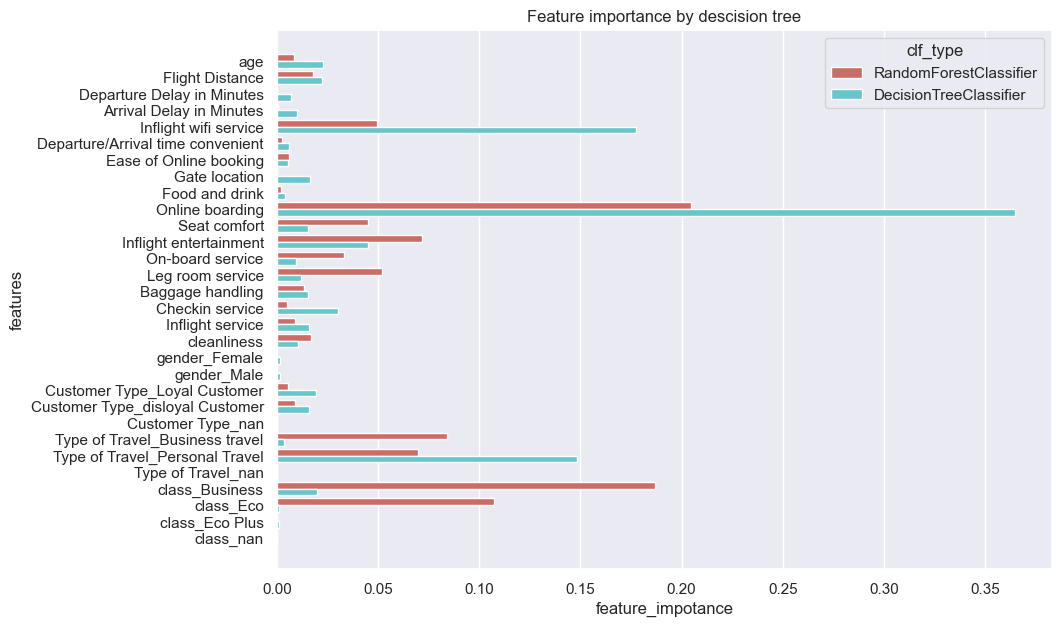

In [367]:
# -__-
barplot_data_rf = pd.DataFrame({
    "feature_impotance": RF_cv.best_estimator_.feature_importances_.tolist(),
    "features": X_train_enc.columns.tolist(),
    "clf_type": "RandomForestClassifier"
})

barplot_data_dt = pd.DataFrame({
    "feature_impotance": DT.feature_importances_.tolist(),
    "features": X_train_enc.columns.tolist(),
    "clf_type": "DecisionTreeClassifier"
})

barplot_data = pd.concat([barplot_data_rf, barplot_data_dt])

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.barplot(barplot_data, x="feature_impotance", y="features", hue="clf_type", palette=sns.color_palette("hls", 2), ax=ax)
ax.set_title("Feature importance by descision tree")
plt.plot()

Бонус (0.5 балла) <font color='#9933CC'>Интерпретируйте важности признаков с помощью SHAP</font>. Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

[Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

In [372]:
# (•_•)
data_sample = X_train_enc.sample(1000)
explainer_ebm = shap.Explainer(RF_cv.best_estimator_.predict, data_sample)
shap_values_ebm = explainer_ebm(data_sample)

PermutationExplainer explainer: 1001it [06:40,  2.44it/s]                          


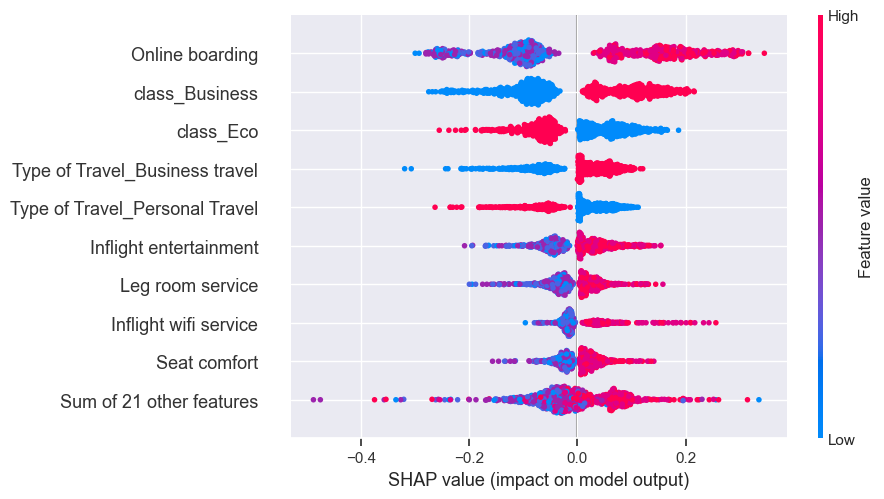

In [373]:
shap.plots.beeswarm(shap_values_ebm)

<font color='#FF6600'>Опишите полученый график</font>

1. Одни из самых важных фичей для модели с точки зрения shap values - Online boarding & class_Business.
2. Чем больше значения фичей Online boarding, class_Business и некоторых других - тем больше вероятность принадлежности классу 1. 
3. Заэнкоженная фича Type of Travel - Business travel и Personal Travel имеют симметричный эффект. Если Business travel = 1, то больше вероятности, что модель даст ответ 1 - пассажир удовлетворен полетом. И наоборот для Personal Travel. 
4. Низкие значения Inflight wifi service и Seat comfort ведут к тому, что модель выдаст значение 0 - пассажир нейтрально или негативно отнесся к полету.

<font color='#FF6600'>Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется? </font>

Можно заплотить waterfall график, который тоже самое, что и beeswarm, только больше показывает влияние фичи в одну сторону. \
Можно построить scatter plot значения фичи относительно shap values, чтобы понять влияние значений фичи на модель. \
Можно построить heatmap фичей по shap values. И еще есть partial_dependence_plot для фичи, который показывает зависимость между таргетом и набором интересующих фичей, отставая от значений всех других фичей. 

Бонус (0.5 балла) <font color='#9933CC'>Интерпретируйте важности признаков с помощью LIME</font>

In [395]:
# please type your solution below
data_sample = X_train_enc.sample(1000, random_state=42)
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_enc.values[:,:], 
                                       feature_names=data_sample.columns,
                                       class_names=['neutral or not satisfied','satisfied'],
                                       )

exp = explainer.explain_instance(data_sample.values[1, :], RF_cv.best_estimator_.predict_proba, num_features=5)
exp.show_in_notebook(show_all=False)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


<font color='#FF6600'>Опишите полученый график</font>

В выбранном кусочке данных часть фичей имеют негативный эффект на модель, такие как class_Business = 0. Фичи Online boarding = 5 и class_Eco = 0 влияют на модель в сторону предикта 1. В целом, вероятность того, что модель предскажет 0 больше на данном кусочке данных.

<font color='#9933CC'>Случайное лес, дающий лучший скор, сохраните в pickle</font>

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?

100/10